In [ ]:
# Install necessary packages
!pip install shap
!pip install SkillMetrics
!pip install tensorflow

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import openpyxl

# Initialize SHAP for interpretability
shap.initjs()

# Define evaluation function
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    return rmse, mse, mae, mape, r2, correlation

# Load data
data = pd.read_csv('/content/pone.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Standardize the data
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the ANN model function
def create_ann():
    model = Sequential()
    model.add(Dense(500, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])
    return model

# Define CSO Optimizer class
class CSO:
    def __init__(self, create_model_func, num_iterations=20, population_size=15):
        self.create_model_func = create_model_func
        self.num_iterations = num_iterations
        self.population_size = population_size

    def optimize(self, X_train, y_train):
        models = [self.create_model_func() for _ in range(self.population_size)]
        fitness = np.array([self.evaluate_fitness(X_train, y_train, model) for model in models])
        best_model_index = np.argmin(fitness)
        best_fitness = fitness[best_model_index]
        best_model = models[best_model_index]

        for i in range(self.num_iterations):
            for j in range(self.population_size):
                if j != best_model_index:
                    models[j] = self.update_model(models[j], best_model)
            fitness = np.array([self.evaluate_fitness(X_train, y_train, model) for model in models])
            best_model_index = np.argmin(fitness)
            if fitness[best_model_index] < best_fitness:
                best_fitness = fitness[best_model_index]
                best_model = models[best_model_index]

        best_model.fit(X_train, y_train, epochs=50, verbose=0, batch_size=32)
        return best_model

    def evaluate_fitness(self, X, y, model):
        model.fit(X, y, epochs=10, verbose=0, batch_size=32)
        predictions = model.predict(X).flatten()
        return mean_squared_error(y, predictions)

    def update_model(self, model, best_model):
        new_model = self.create_model_func()
        return new_model

# Define MFO Optimizer class
class MFO:
    def __init__(self, create_model_func, num_iterations=20, population_size=15):
        self.create_model_func = create_model_func
        self.num_iterations = num_iterations
        self.population_size = population_size

    def optimize(self, X_train, y_train):
        models = [self.create_model_func() for _ in range(self.population_size)]
        fitness = np.array([self.evaluate_fitness(X_train, y_train, model) for model in models])

        flames = models[:]
        flame_fitness = fitness[:]
        best_fitness = np.min(flame_fitness)
        best_model = flames[np.argmin(flame_fitness)]

        for i in range(self.num_iterations):
            for j in range(self.population_size):
                distance = (1 - (i / self.num_iterations)) * np.random.rand()
                if fitness[j] < flame_fitness[j]:
                    flames[j] = models[j]
                    flame_fitness[j] = fitness[j]
                models[j] = self.update_model(models[j], flames[j], distance)

            fitness = np.array([self.evaluate_fitness(X_train, y_train, model) for model in models])
            best_model_index = np.argmin(fitness)
            if fitness[best_model_index] < best_fitness:
                best_fitness = fitness[best_model_index]
                best_model = models[best_model_index]

        best_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        return best_model

    def evaluate_fitness(self, X, y, model):
        model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        predictions = model.predict(X)
        return mean_squared_error(y, predictions.flatten())

    def update_model(self, model, flame, distance):
        new_model = self.create_model_func()
        return new_model

# Optimize models using both CSO and MFO
cso_optimizer = CSO(create_ann)
ann_cso = cso_optimizer.optimize(X_train, y_train)

mfo_optimizer = MFO(create_ann)
ann_mfo = mfo_optimizer.optimize(X_train, y_train)

# Train a baseline ANN
ann = create_ann()
ann.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate all models
ann_train_predictions = ann.predict(X_train).flatten()
ann_test_predictions = ann.predict(X_test).flatten()

ann_cso_train_predictions = ann_cso.predict(X_train).flatten()
ann_cso_test_predictions = ann_cso.predict(X_test).flatten()

ann_mfo_train_predictions = ann_mfo.predict(X_train).flatten()
ann_mfo_test_predictions = ann_mfo.predict(X_test).flatten()

# Compute metrics
ann_metrics_train = evaluate_model(y_train, ann_train_predictions)
ann_metrics_test = evaluate_model(y_test, ann_test_predictions)

ann_cso_metrics_train = evaluate_model(y_train, ann_cso_train_predictions)
ann_cso_metrics_test = evaluate_model(y_test, ann_cso_test_predictions)

ann_mfo_metrics_train = evaluate_model(y_train, ann_mfo_train_predictions)
ann_mfo_metrics_test = evaluate_model(y_test, ann_mfo_test_predictions)

# Save metrics and predictions to Excel
train_indices = range(len(X_train))
test_indices = range(len(X_test))

train_df = pd.DataFrame({
    'Index': train_indices,
    'ANN_Train_Predictions': ann_train_predictions,
    'ANN-CSO_Train_Predictions': ann_cso_train_predictions,
    'ANN-MFO_Train_Predictions': ann_mfo_train_predictions,
})

test_df = pd.DataFrame({
    'Index': test_indices,
    'ANN_Test_Predictions': ann_test_predictions,
    'ANN-CSO_Test_Predictions': ann_cso_test_predictions,
    'ANN-MFO_Test_Predictions': ann_mfo_test_predictions,
})

metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE', 'R2', 'Correlation'],
    'ANN_Training': ann_metrics_train,
    'ANN_Testing': ann_metrics_test,
    'ANN-CSO_Training': ann_cso_metrics_train,
    'ANN-CSO_Testing': ann_cso_metrics_test,
    'ANN-MFO_Training': ann_mfo_metrics_train,
    'ANN-MFO_Testing': ann_mfo_metrics_test,
})

with pd.ExcelWriter('ann_predictions_and_metrics.xlsx') as writer:
    train_df.to_excel(writer, sheet_name='Train_Predictions', index=False)
    test_df.to_excel(writer, sheet_name='Test_Predictions', index=False)
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)

print("Predictions and metrics saved to ann_predictions_and_metrics.xlsx")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 5.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predictions and metrics saved to ann_predictions_and_metrics.xlsx


In [ ]:
# prompt: # prompt: generate the models accuracy, sensitivity, specificity, precision, and f score by making it binary CLASS

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'y_test' and 'ann_test_predictions' are your true and predicted values.
# Convert predictions to binary classification (e.g., using a threshold)
threshold = np.mean(y_test)  # Or another appropriate threshold
y_pred_binary = (ann_test_predictions >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)


# Calculate metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
sensitivity = recall_score(y_test_binary, y_pred_binary)  # Sensitivity is the same as recall
specificity = confusion_matrix(y_test_binary, y_pred_binary)[0, 0] / (confusion_matrix(y_test_binary, y_pred_binary)[0, 0] + confusion_matrix(y_test_binary, y_pred_binary)[0, 1])
f1 = f1_score(y_test_binary, y_pred_binary)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")

# Repeat the above calculations for ann_cso_test_predictions and ann_mfo_test_predictions
# ... (similar code as above but replace ann_test_predictions)

Accuracy: 0.75
Precision: 0.6666666666666666
Sensitivity (Recall): 1.0
Specificity: 0.5
F1 Score: 0.8


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'y_test' and 'ann_test_predictions' are your true and predicted values.
# Convert predictions to binary classification (e.g., using a threshold)
threshold = np.mean(y_test)  # Or another appropriate threshold
y_pred_binary = (ann_cso_test_predictions >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)


# Calculate metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
sensitivity = recall_score(y_test_binary, y_pred_binary)  # Sensitivity is the same as recall
specificity = confusion_matrix(y_test_binary, y_pred_binary)[0, 0] / (confusion_matrix(y_test_binary, y_pred_binary)[0, 0] + confusion_matrix(y_test_binary, y_pred_binary)[0, 1])
f1 = f1_score(y_test_binary, y_pred_binary)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")

Accuracy: 0.625
Precision: 0.5714285714285714
Sensitivity (Recall): 1.0
Specificity: 0.25
F1 Score: 0.7272727272727273


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'y_test' and 'ann_test_predictions' are your true and predicted values.
# Convert predictions to binary classification (e.g., using a threshold)
threshold = np.mean(y_test)  # Or another appropriate threshold
# Repeat the above calculations for ann_cso_test_predictions and ann_mfo_test_predictions
y_pred_binary = (ann_mfo_test_predictions >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)


# Calculate metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
sensitivity = recall_score(y_test_binary, y_pred_binary)  # Sensitivity is the same as recall
specificity = confusion_matrix(y_test_binary, y_pred_binary)[0, 0] / (confusion_matrix(y_test_binary, y_pred_binary)[0, 0] + confusion_matrix(y_test_binary, y_pred_binary)[0, 1])
f1 = f1_score(y_test_binary, y_pred_binary)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")

Accuracy: 0.6875
Precision: 0.6153846153846154
Sensitivity (Recall): 1.0
Specificity: 0.375
F1 Score: 0.7619047619047619


In [ ]:
# prompt: # prompt: print them (accuracy, sensitivity, specificity, precision, and f score) in excel sheet
from openpyxl import load_workbook

# Load the existing Excel file
existing_file = 'ann_predictions_and_metrics.xlsx'

# Create the classification metrics DataFrame
classification_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score'],
    'ANN_Testing': [accuracy, sensitivity, specificity, precision, f1_score]
})

# Append the classification metrics to the existing Excel file using openpyxl
with pd.ExcelWriter(existing_file, engine='openpyxl', mode='a') as writer:
    classification_metrics_df.to_excel(writer, sheet_name='Classification_Metrics', index=False)

print("Classification metrics appended to the existing Excel file.")

Classification metrics appended to the existing Excel file.


In [ ]:
# prompt: # prompt: Compute Akaike information criterion SCORE for ANN, ANN-CSO and ANN-MFO

import numpy as np

# Assuming you have the number of parameters (k) for each model:
k_ann = 55  # Replace with the actual number of parameters for ANN
k_ann_cso = 55 # Replace with the actual number of parameters for ANN-CSO
k_ann_mfo = 55 # Replace with the actual number of parameters for ANN-MFO


# Assuming you have the negative log-likelihood for each model (L):
# Replace with your actual log-likelihood calculations
L_ann = -np.mean(np.square(y_test - ann_test_predictions)) # Example: MSE for regression (negative for minimizing)
L_ann_cso = -np.mean(np.square(y_test - ann_cso_test_predictions)) # Example: MSE for regression (negative for minimizing)
L_ann_mfo = -np.mean(np.square(y_test - ann_mfo_test_predictions)) # Example: MSE for regression (negative for minimizing)


# Calculate AIC scores
AIC_ann = 2 * k_ann - 2 * L_ann
AIC_ann_cso = 2 * k_ann_cso - 2 * L_ann_cso
AIC_ann_mfo = 2 * k_ann_mfo - 2 * L_ann_mfo

print(f"AIC for ANN: {AIC_ann}")
print(f"AIC for ANN-CSO: {AIC_ann_cso}")
print(f"AIC for ANN-MFO: {AIC_ann_mfo}")

# Append AIC scores to metrics DataFrame
new_metrics_df = pd.DataFrame({
    'Metric': ['AIC'],
    'ANN_Testing': AIC_ann,
    'ANN-CSO_Testing': AIC_ann_cso,
    'ANN-MFO_Testing': AIC_ann_mfo,
})
import pandas as pd
from openpyxl import load_workbook

# Assuming `new_metrics_df` is your new DataFrame containing the metrics data
file_path = 'ann_predictions_and_metrics.xlsx'

# Open the existing Excel file and load the workbook
book = load_workbook(file_path)

# Check if the 'Metrics' sheet exists
if 'Metrics' in book.sheetnames:
    # Load existing sheet into a DataFrame
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
        # Find the existing data and calculate the starting row
        metrics_sheet = book['Metrics']
        start_row = metrics_sheet.max_row  # Find the last row
        new_metrics_df.to_excel(writer, sheet_name='Metrics', index=False, header=False, startrow=start_row)
else:
    # If the 'Metrics' sheet doesn't exist, create it
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
        new_metrics_df.to_excel(writer, sheet_name='Metrics', index=False)

print("Metrics appended successfully.")


AIC for ANN: 749.5878007157648
AIC for ANN-CSO: 869.775900069772
AIC for ANN-MFO: 854.2224340863177
Metrics appended successfully.


In [ ]:
# prompt: # prompt: Calculate confusion matrix for ANN, ANN-CSO and ANN-MFO

# ... (Your existing code)

# Confusion Matrix Calculation
def calculate_confusion_matrix(y_true, y_pred, threshold):
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_true_binary = (y_true >= threshold).astype(int)
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    return cm

# Calculate and print confusion matrices
threshold = np.mean(y_test)
cm_ann = calculate_confusion_matrix(y_test, ann_test_predictions, threshold)
cm_ann_cso = calculate_confusion_matrix(y_test, ann_cso_test_predictions, threshold)
cm_ann_mfo = calculate_confusion_matrix(y_test, ann_mfo_test_predictions, threshold)

print("Confusion Matrix for ANN:")
print(cm_ann)
print("\nConfusion Matrix for ANN-CSO:")
print(cm_ann_cso)
print("\nConfusion Matrix for ANN-MFO:")
print(cm_ann_mfo)


# Append confusion matrices to Excel (using openpyxl)

from openpyxl.utils.dataframe import dataframe_to_rows

def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False,
                       **to_excel_kwargs):
    from openpyxl import load_workbook

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl')

    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)

        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)

        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()


# Create DataFrames for confusion matrices
cm_ann_df = pd.DataFrame(cm_ann)
cm_ann_cso_df = pd.DataFrame(cm_ann_cso)
cm_ann_mfo_df = pd.DataFrame(cm_ann_mfo)


# Append confusion matrices to Excel
append_df_to_excel('ann_predictions_and_metrics.xlsx', cm_ann_df, sheet_name='Confusion_Matrices', startrow=0, index=False, header=True)
append_df_to_excel('ann_predictions_and_metrics.xlsx', cm_ann_cso_df, sheet_name='Confusion_Matrices', startrow=cm_ann_df.shape[0] + 2, index=False, header=True)
append_df_to_excel('ann_predictions_and_metrics.xlsx', cm_ann_mfo_df, sheet_name='Confusion_Matrices', startrow=cm_ann_df.shape[0] + cm_ann_cso_df.shape[0] + 4, index=False, header=True)


print("Confusion matrices appended to Excel file.")

Confusion Matrix for ANN:
[[4 4]
 [0 8]]

Confusion Matrix for ANN-CSO:
[[2 6]
 [0 8]]

Confusion Matrix for ANN-MFO:
[[3 5]
 [0 8]]


BadZipFile: File is not a zip file

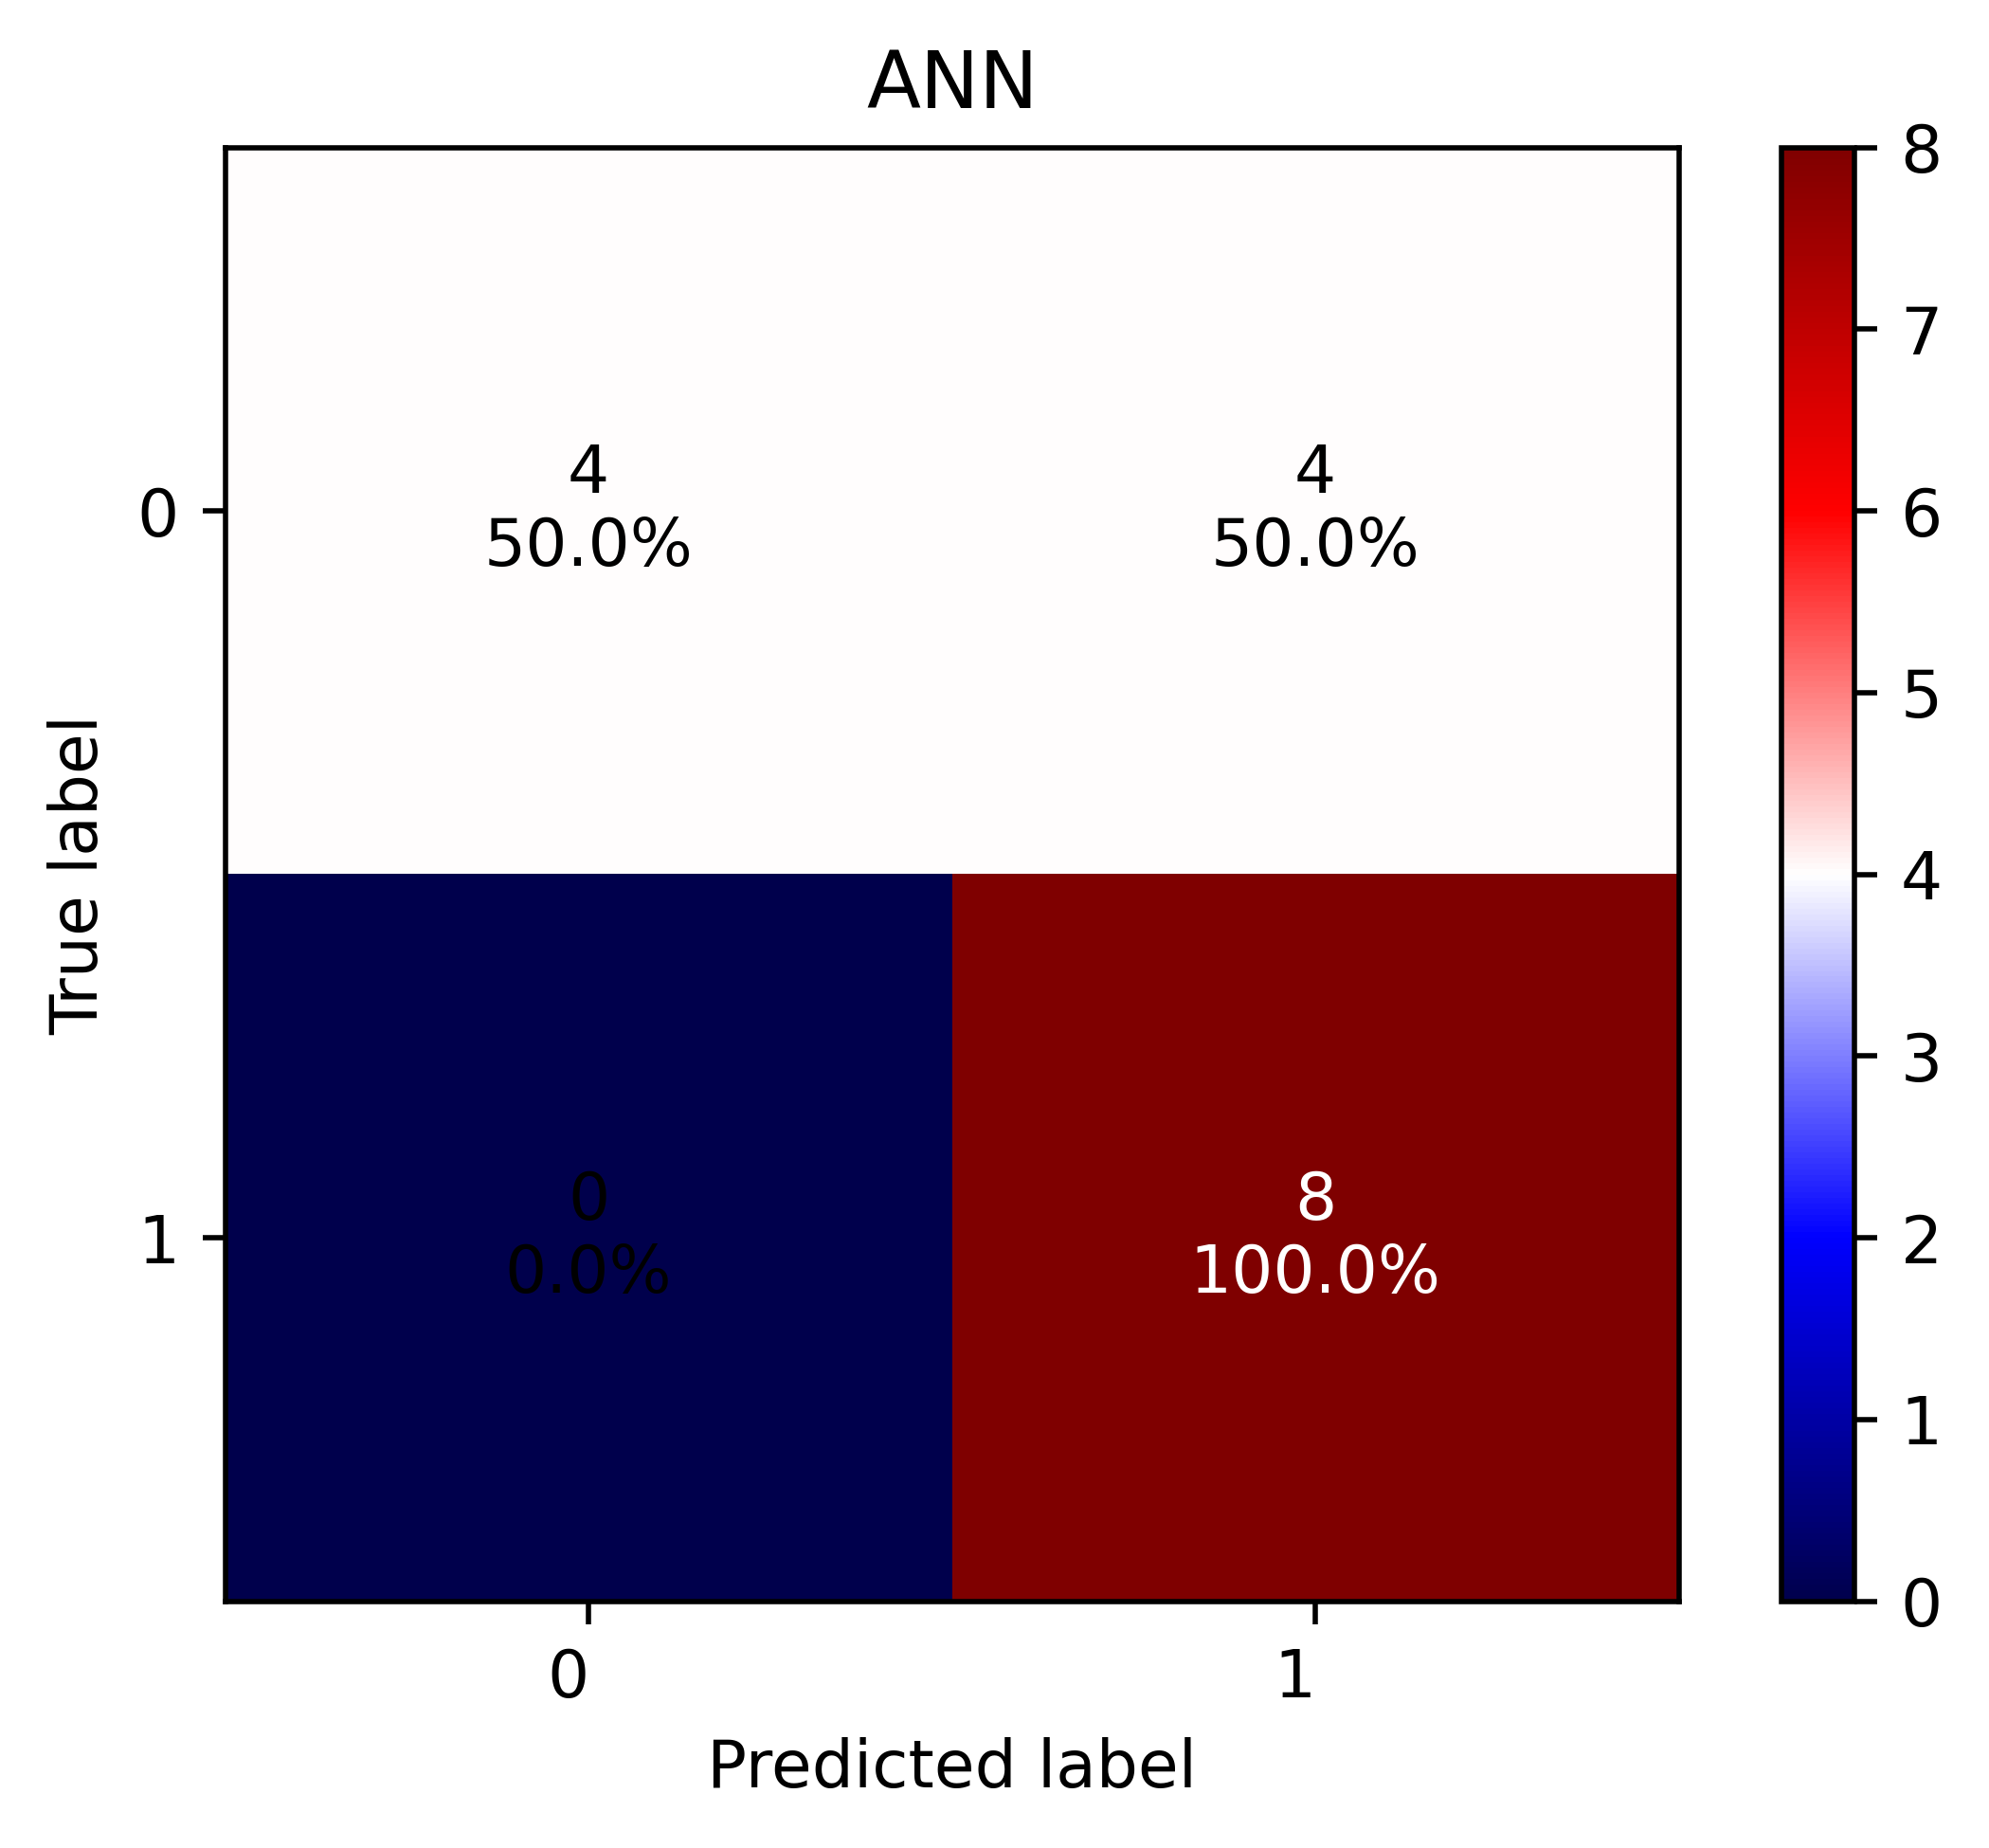

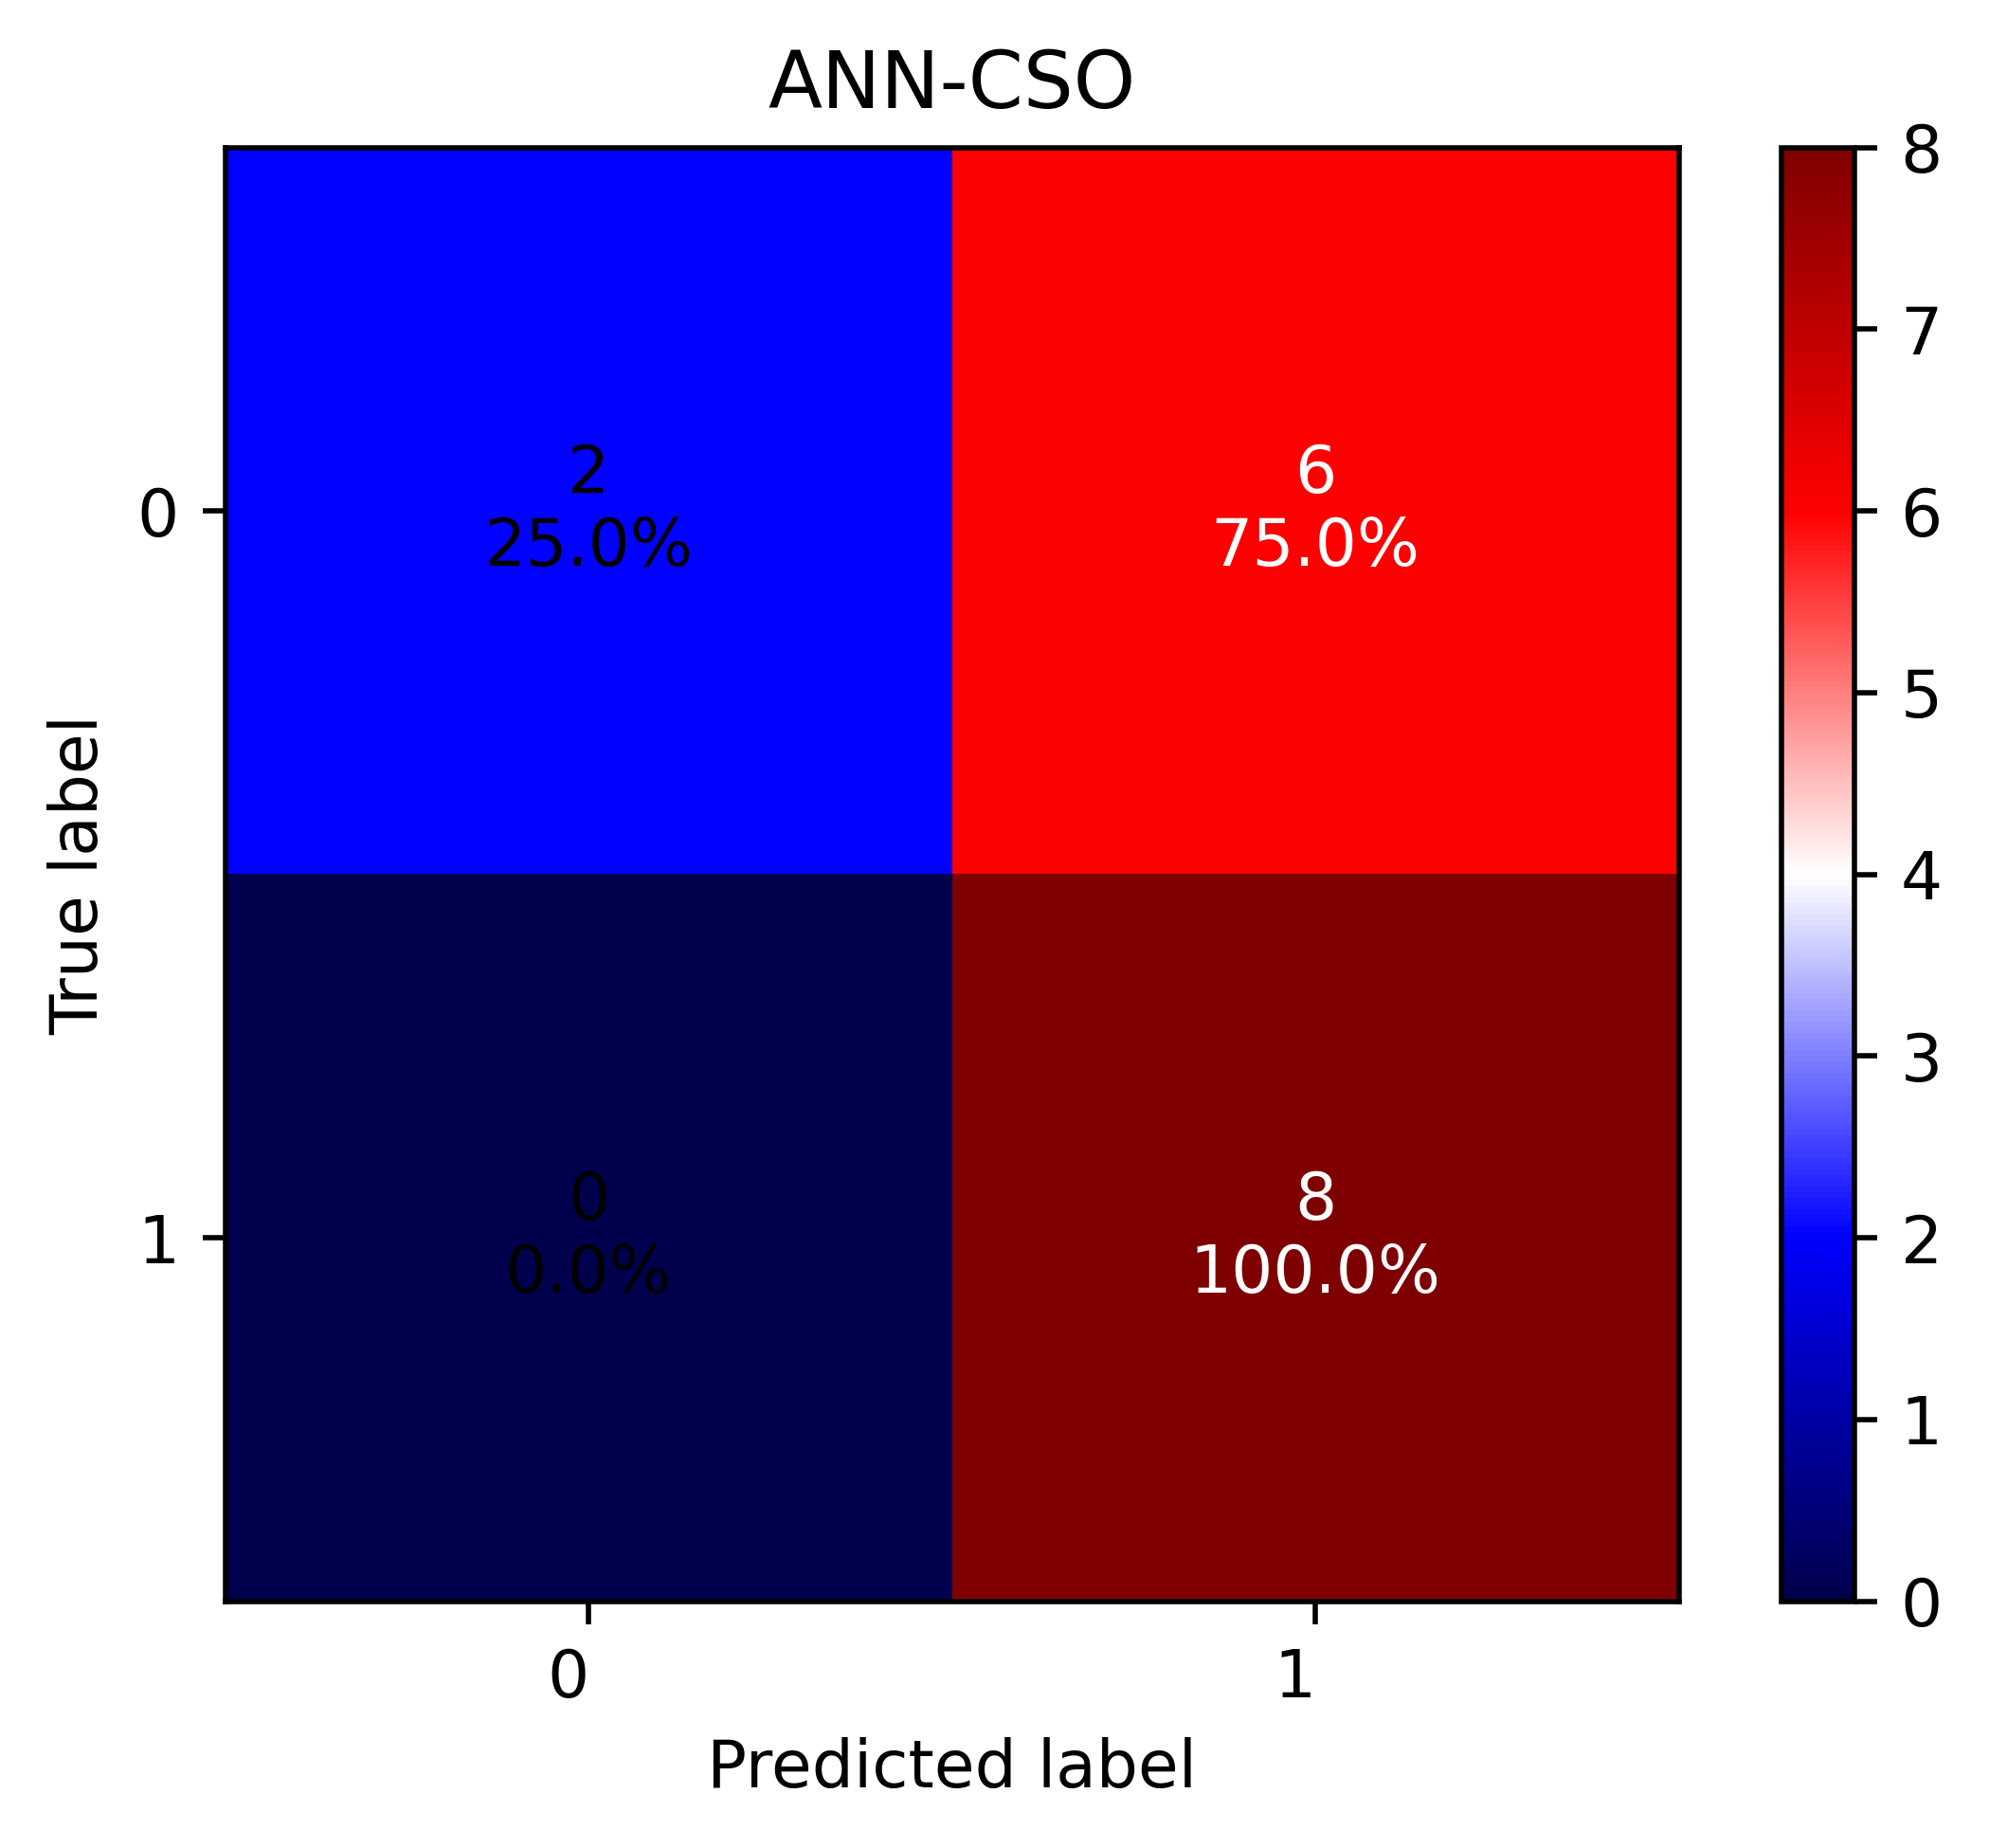

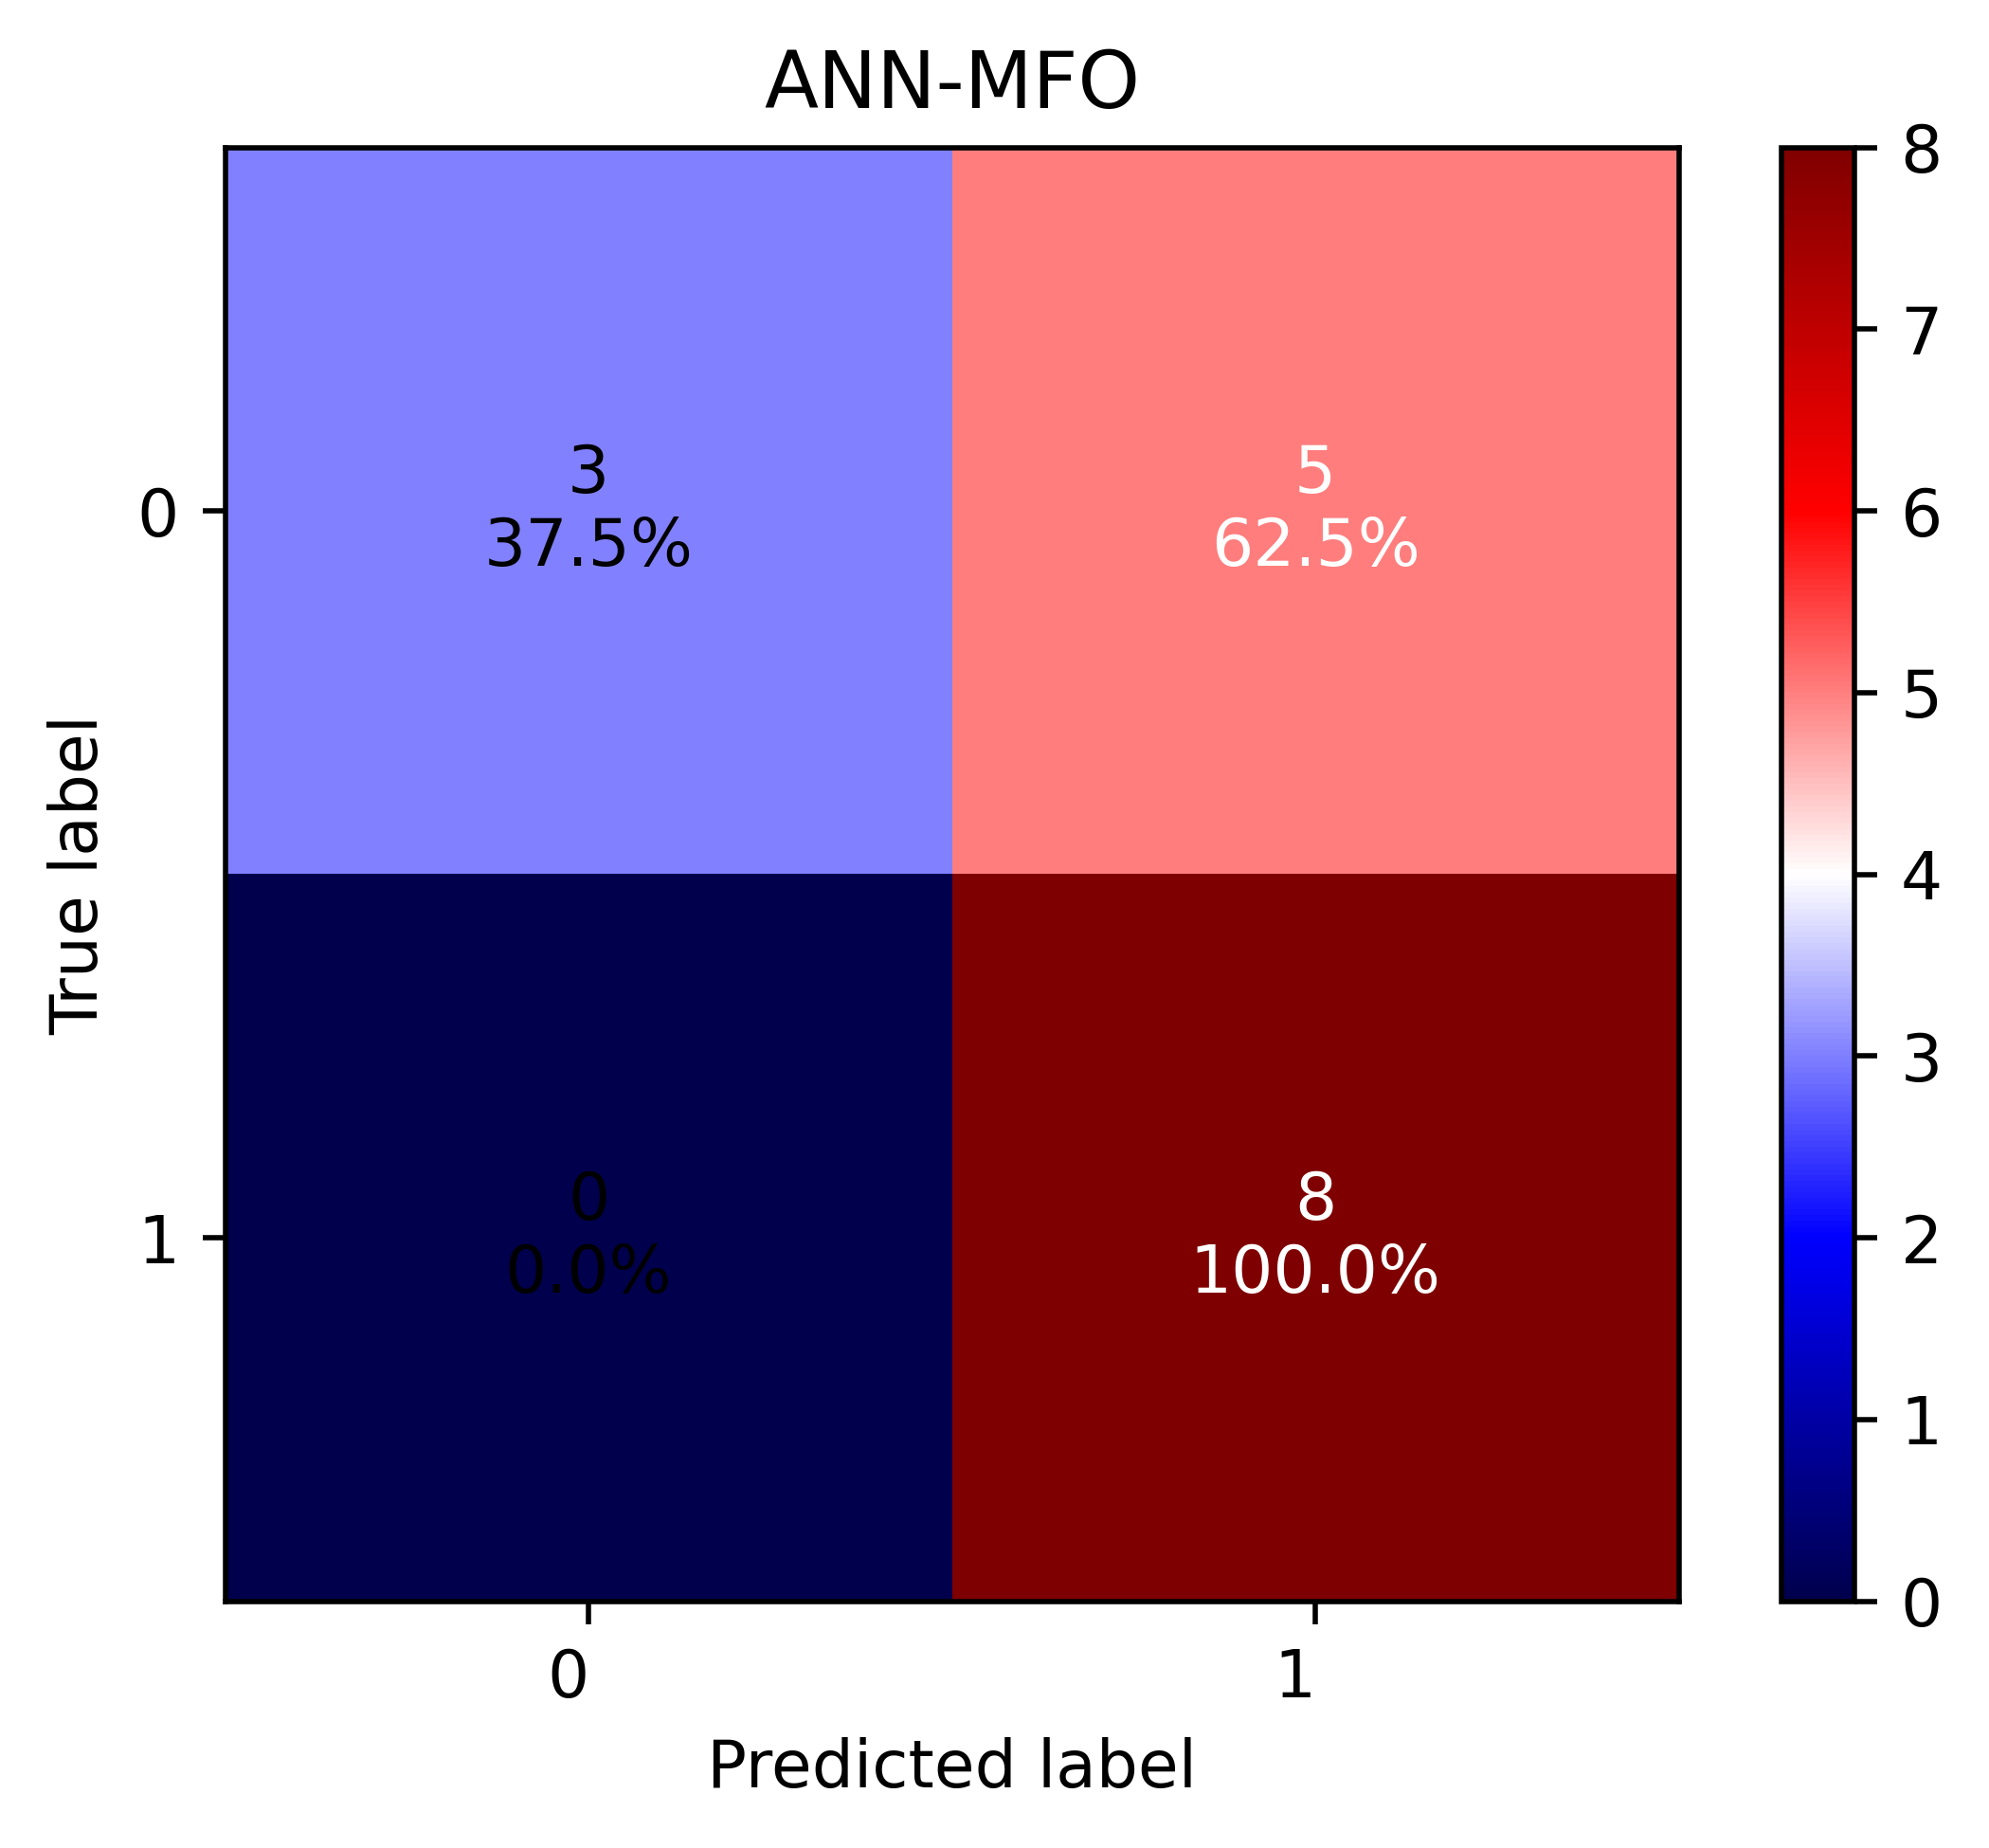

In [ ]:
# prompt: plot the confusion matrix graph for ANN, ANN-CSO and ANN-MFO separately, SHOWING THE digits and PERCENTAGES one on top of the other in the same graph

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title, threshold):
    cm = confusion_matrix( (y_true >= threshold).astype(int), (y_pred >= threshold).astype(int))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, ax = plt.subplots(figsize=(5, 4), dpi=500)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.seismic)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['0', '1'], yticklabels=['0', '1'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt) + '\n' + format(cm_percentage[i,j],'.1f') + '%',
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Example usage (replace with your actual data and predictions):
threshold = np.mean(y_test)
plot_confusion_matrix(y_test, ann_test_predictions, "ANN", threshold)
plot_confusion_matrix(y_test, ann_cso_test_predictions, "ANN-CSO", threshold)
plot_confusion_matrix(y_test, ann_mfo_test_predictions, "ANN-MFO", threshold)

AUPRC for ANN: 0.8076923076923077
AUPRC for ANN-CSO: 0.7857142857142857
AUPRC for ANN-MFO: 0.8076923076923077


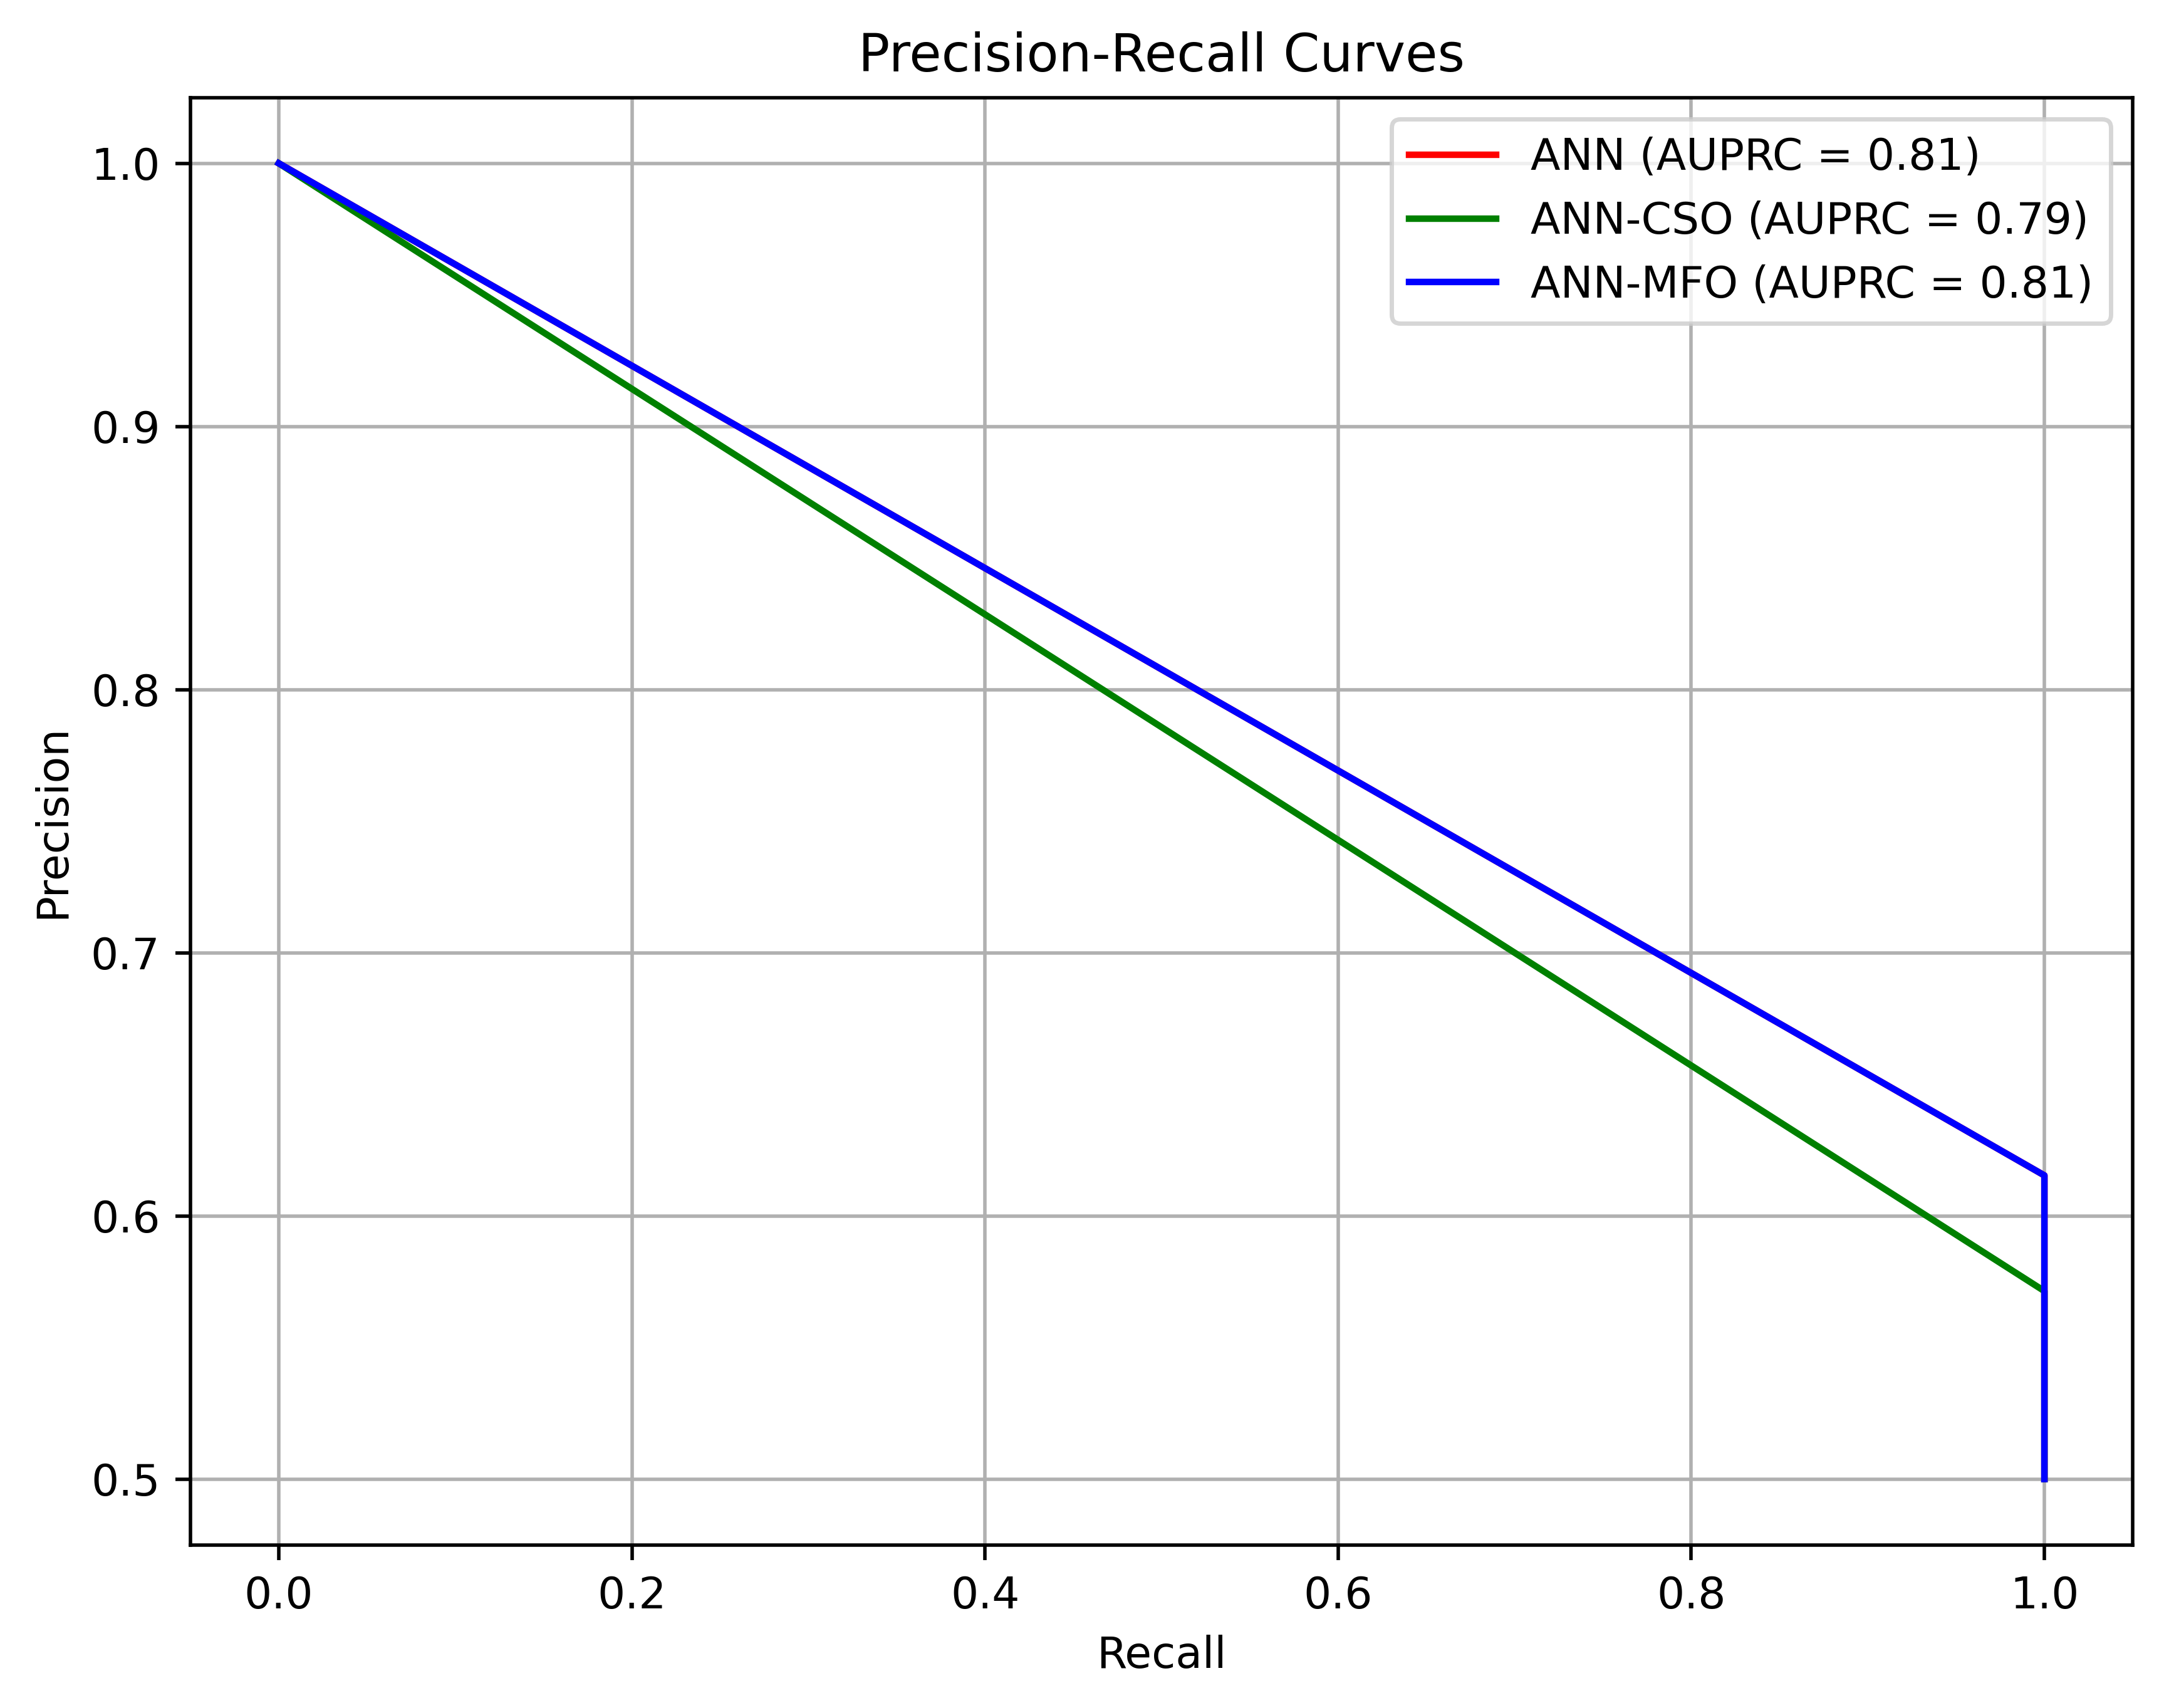

In [ ]:
# prompt: # prompt: COMPUTE Area under the precision-Recall curve (AUPRC) for ANN, ANN-CSO AND ANN-MFO PLOT THE GRAPHS. MAKE IT BINARY class

from sklearn.metrics import precision_recall_curve, auc

# Calculate precision-recall curve and AUPRC for each model
precision_ann, recall_ann, _ = precision_recall_curve(y_test_binary, y_pred_binary)
auprc_ann = auc(recall_ann, precision_ann)

# ... (similar code for ann_cso and ann_mfo)

precision_ann_cso, recall_ann_cso, _ = precision_recall_curve(y_test_binary, (ann_cso_test_predictions >= threshold).astype(int))
auprc_ann_cso = auc(recall_ann_cso, precision_ann_cso)

precision_ann_mfo, recall_ann_mfo, _ = precision_recall_curve(y_test_binary, (ann_mfo_test_predictions >= threshold).astype(int))
auprc_ann_mfo = auc(recall_ann_mfo, precision_ann_mfo)


print(f"AUPRC for ANN: {auprc_ann}")
print(f"AUPRC for ANN-CSO: {auprc_ann_cso}")
print(f"AUPRC for ANN-MFO: {auprc_ann_mfo}")


# Append AUPRC scores to metrics DataFrame in Excel
new_metrics_df = pd.DataFrame({
    'Metric': ['AUPRC'],
    'ANN_Testing': auprc_ann,
    'ANN-CSO_Testing': auprc_ann_cso,
    'ANN-MFO_Testing': auprc_ann_mfo,
})

# ... (Your existing code to append the DataFrame to the excel file)

# Plot the precision-recall curves
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(recall_ann, precision_ann, color='red', label=f'ANN (AUPRC = {auprc_ann:.2f})')
plt.plot(recall_ann_cso, precision_ann_cso, color='green', label=f'ANN-CSO (AUPRC = {auprc_ann_cso:.2f})')
plt.plot(recall_ann_mfo, precision_ann_mfo, color='blue', label=f'ANN-MFO (AUPRC = {auprc_ann_mfo:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

AUPRC for ANN: 0.8333333333333333


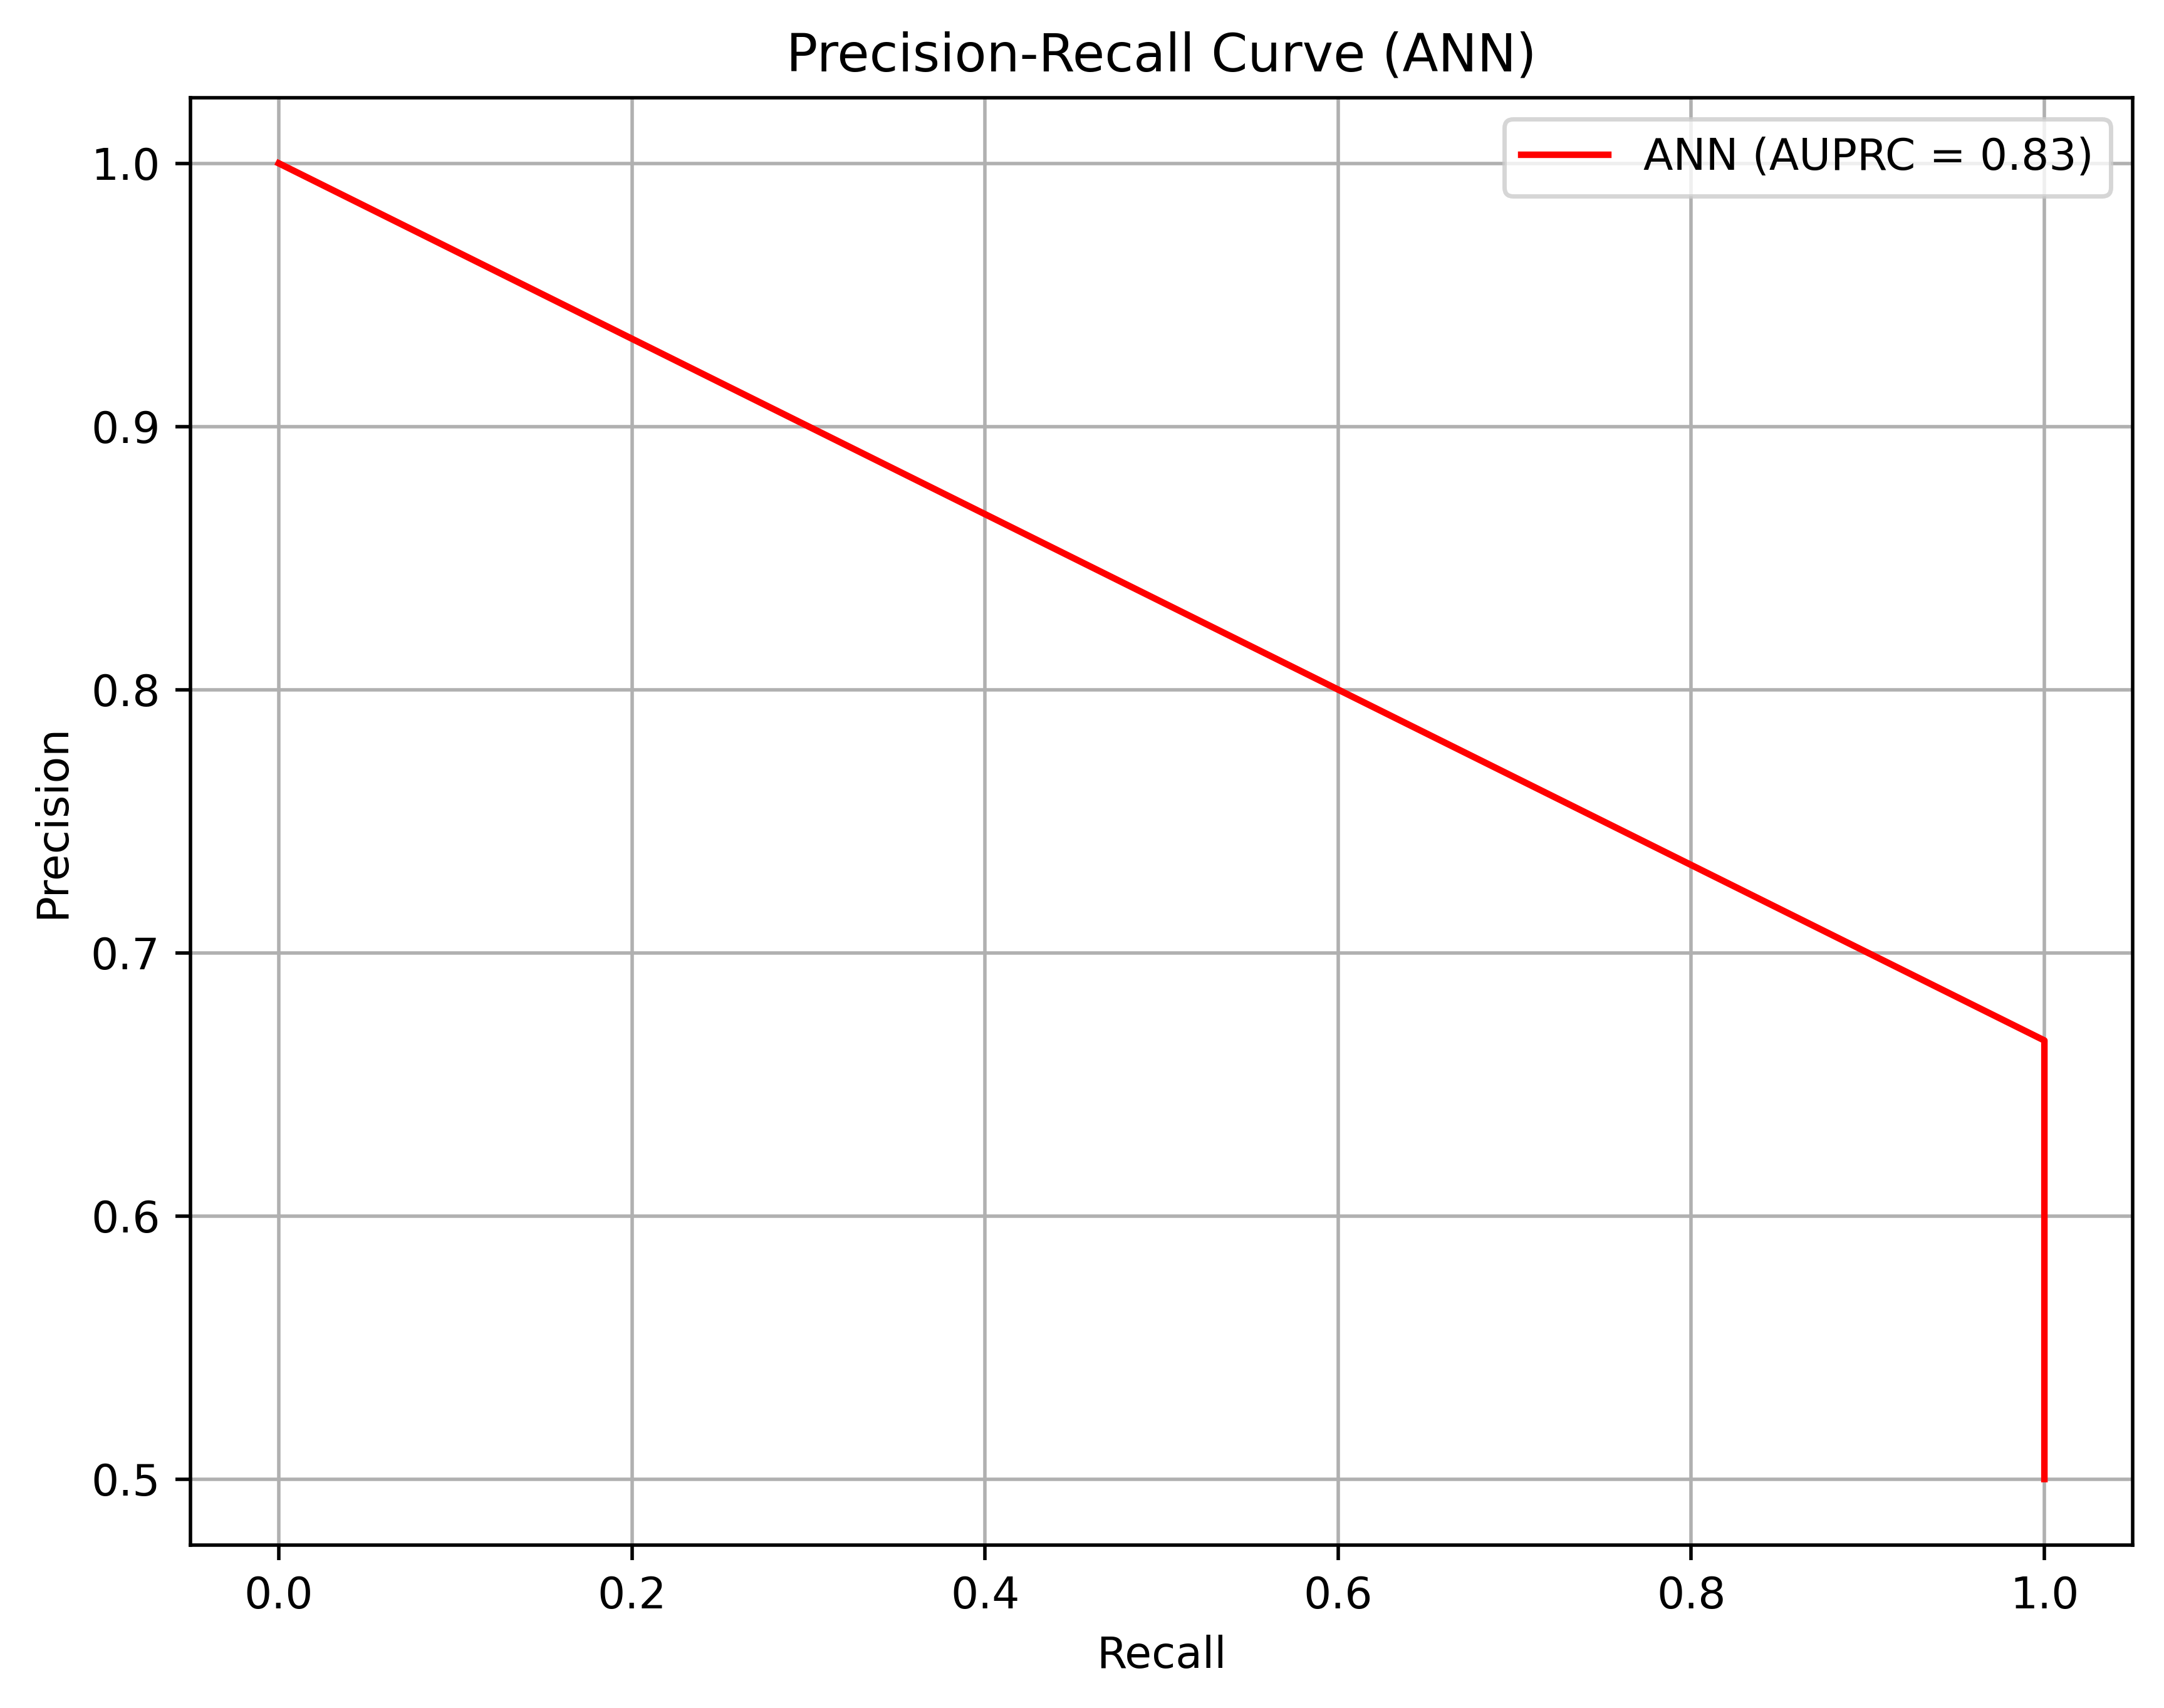

In [ ]:
# prompt: # prompt: COMPUTE Area under the precision-Recall curve (AUPRC) for ANN only, PLOT THE GRAPHS. MAKE IT BINARY class

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Assuming y_test, ann_test_predictions, ann_cso_test_predictions, and ann_mfo_test_predictions are defined

# Calculate precision-recall curve and AUPRC for ANN only
threshold = np.mean(y_test)
y_pred_binary = (ann_test_predictions >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)

precision_ann, recall_ann, _ = precision_recall_curve(y_test_binary, y_pred_binary)
auprc_ann = auc(recall_ann, precision_ann)

print(f"AUPRC for ANN: {auprc_ann}")

# Plot the precision-recall curve for ANN only
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(recall_ann, precision_ann, color='red', label=f'ANN (AUPRC = {auprc_ann:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (ANN)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

AUPRC for ANN-CSO: 0.7857142857142857


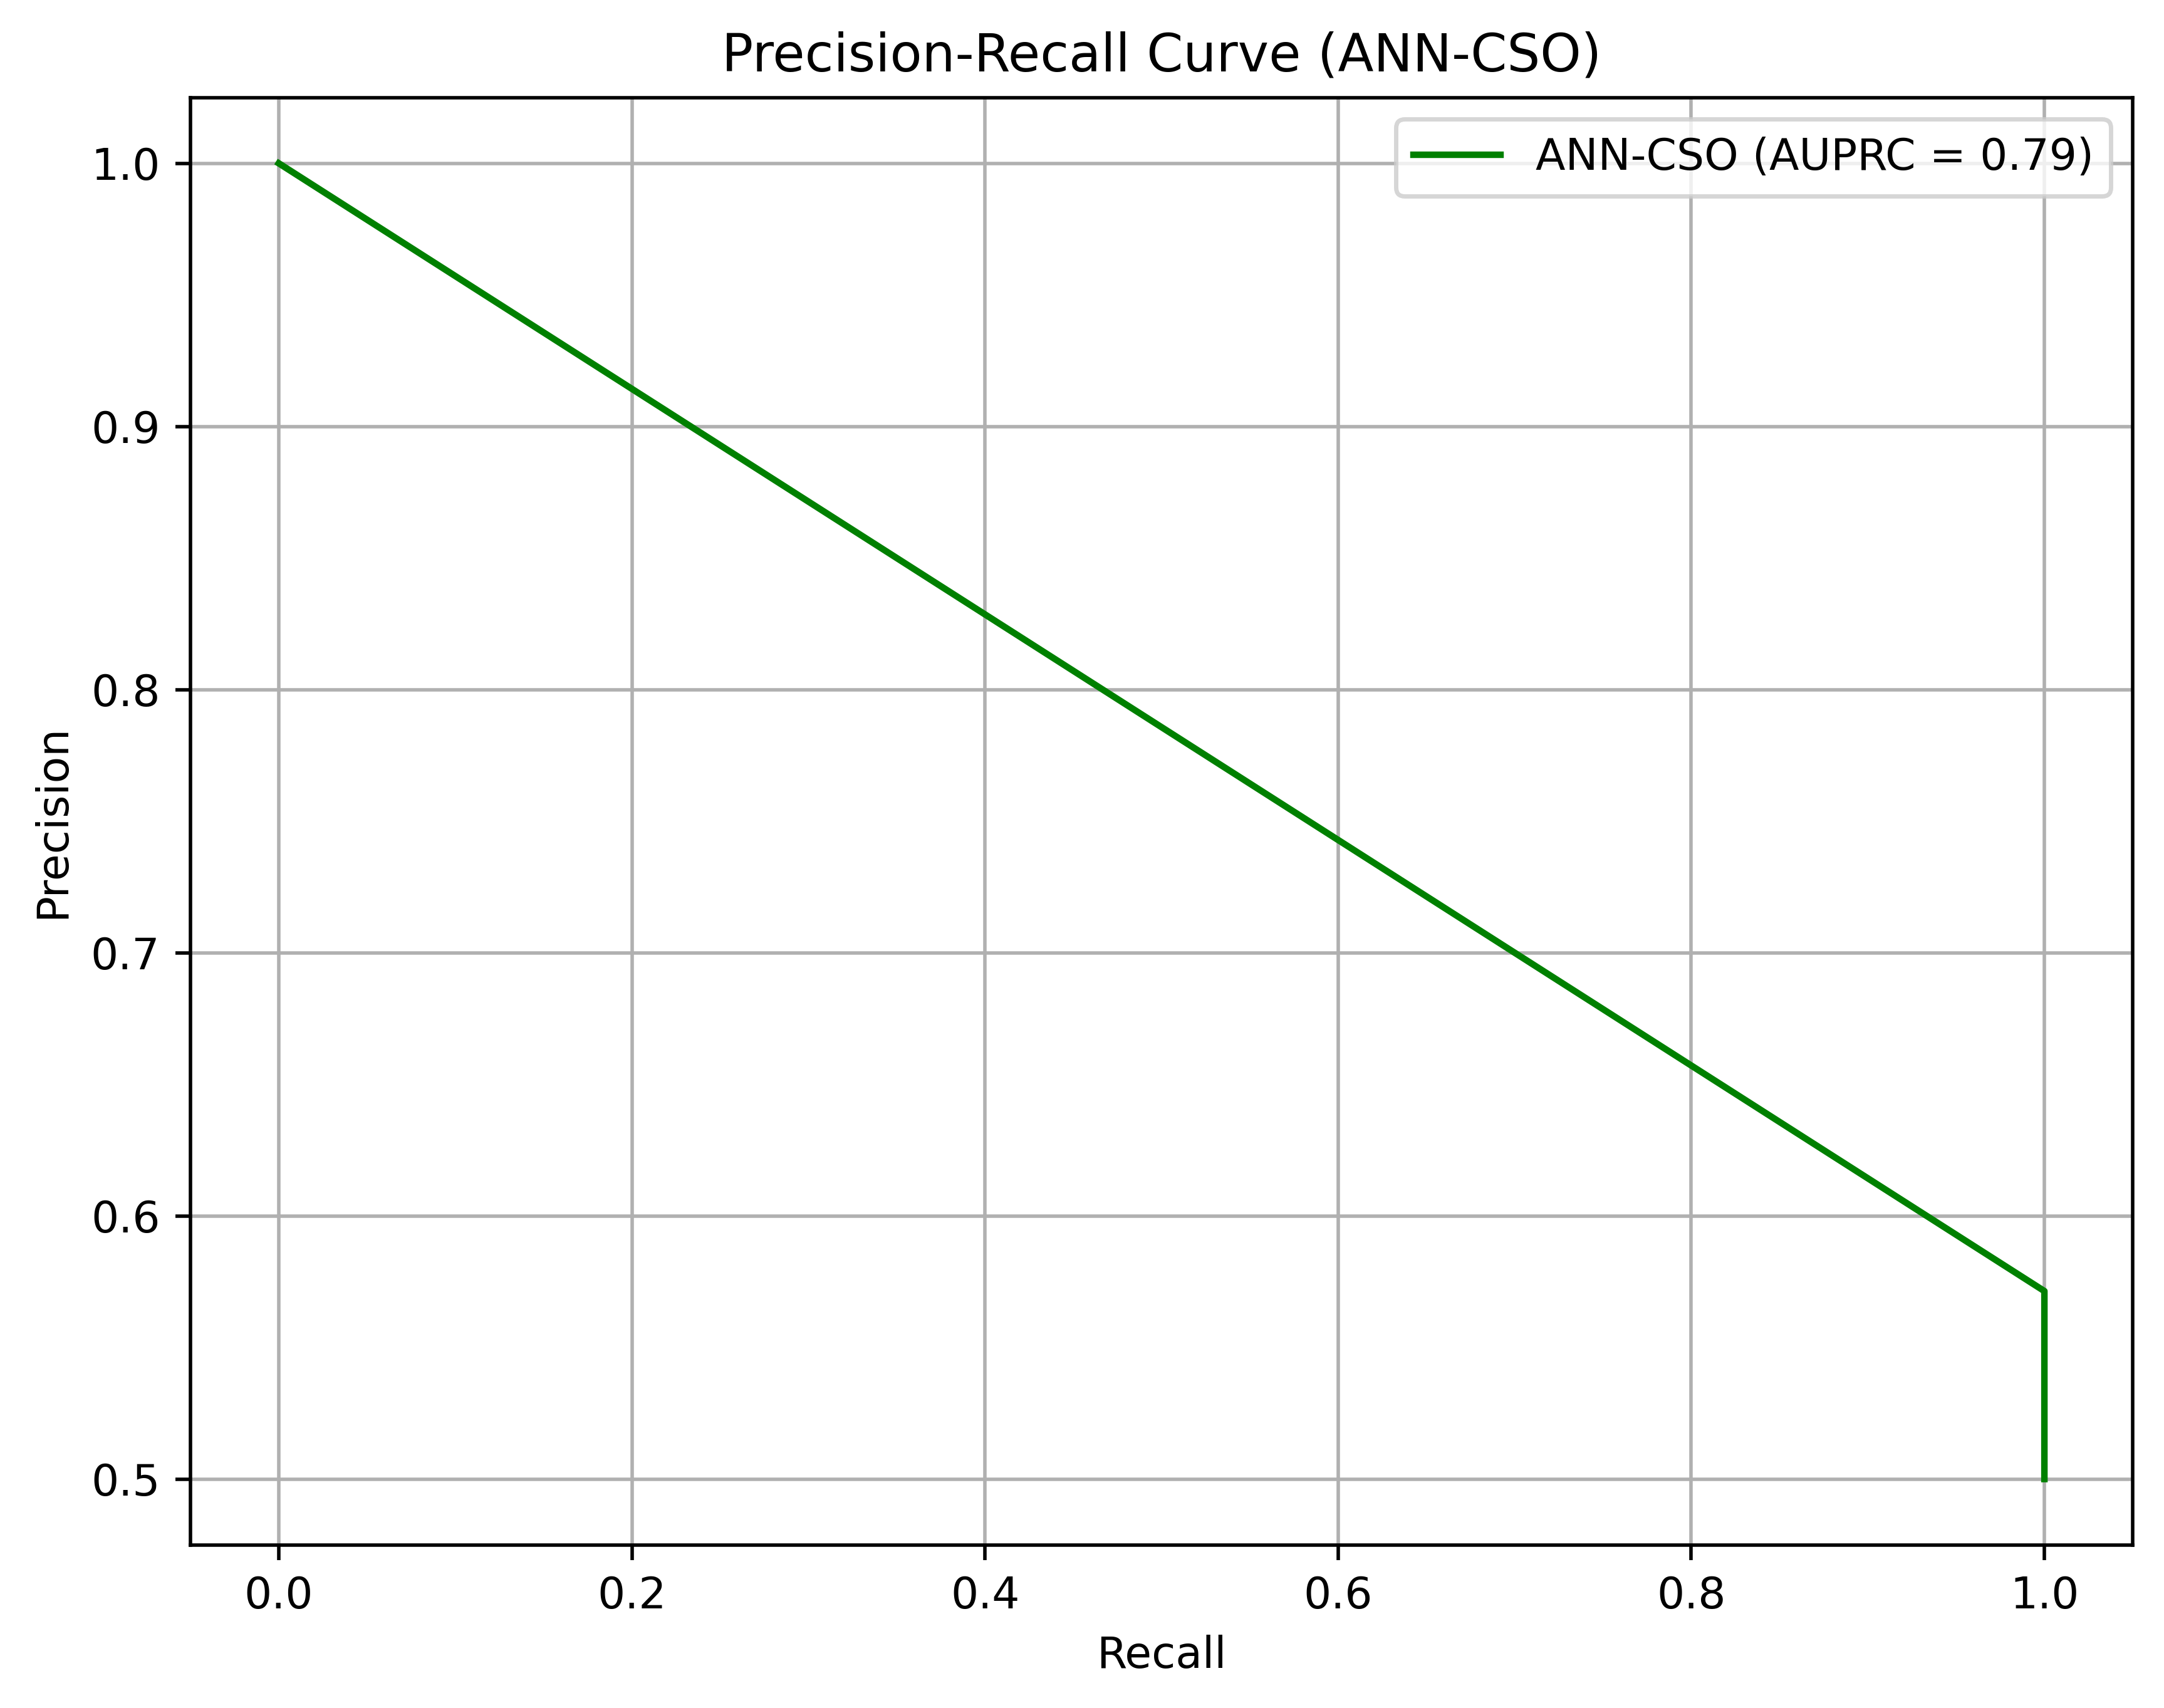

In [ ]:
# prompt: # prompt: COMPUTE Area under the precision-Recall curve (AUPRC) for ANN-CSO only, PLOT THE GRAPHS. MAKE IT BINARY class

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Assuming y_test and ann_cso_test_predictions are defined

# Calculate precision-recall curve and AUPRC for ANN-CSO
threshold = np.mean(y_test)
y_pred_cso_binary = (ann_cso_test_predictions >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)

precision_ann_cso, recall_ann_cso, _ = precision_recall_curve(y_test_binary, y_pred_cso_binary)
auprc_ann_cso = auc(recall_ann_cso, precision_ann_cso)

print(f"AUPRC for ANN-CSO: {auprc_ann_cso}")

# Plot the precision-recall curve for ANN-CSO
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(recall_ann_cso, precision_ann_cso, color='green', label=f'ANN-CSO (AUPRC = {auprc_ann_cso:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (ANN-CSO)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

AUPRC for ANN-MFO: 0.8076923076923077


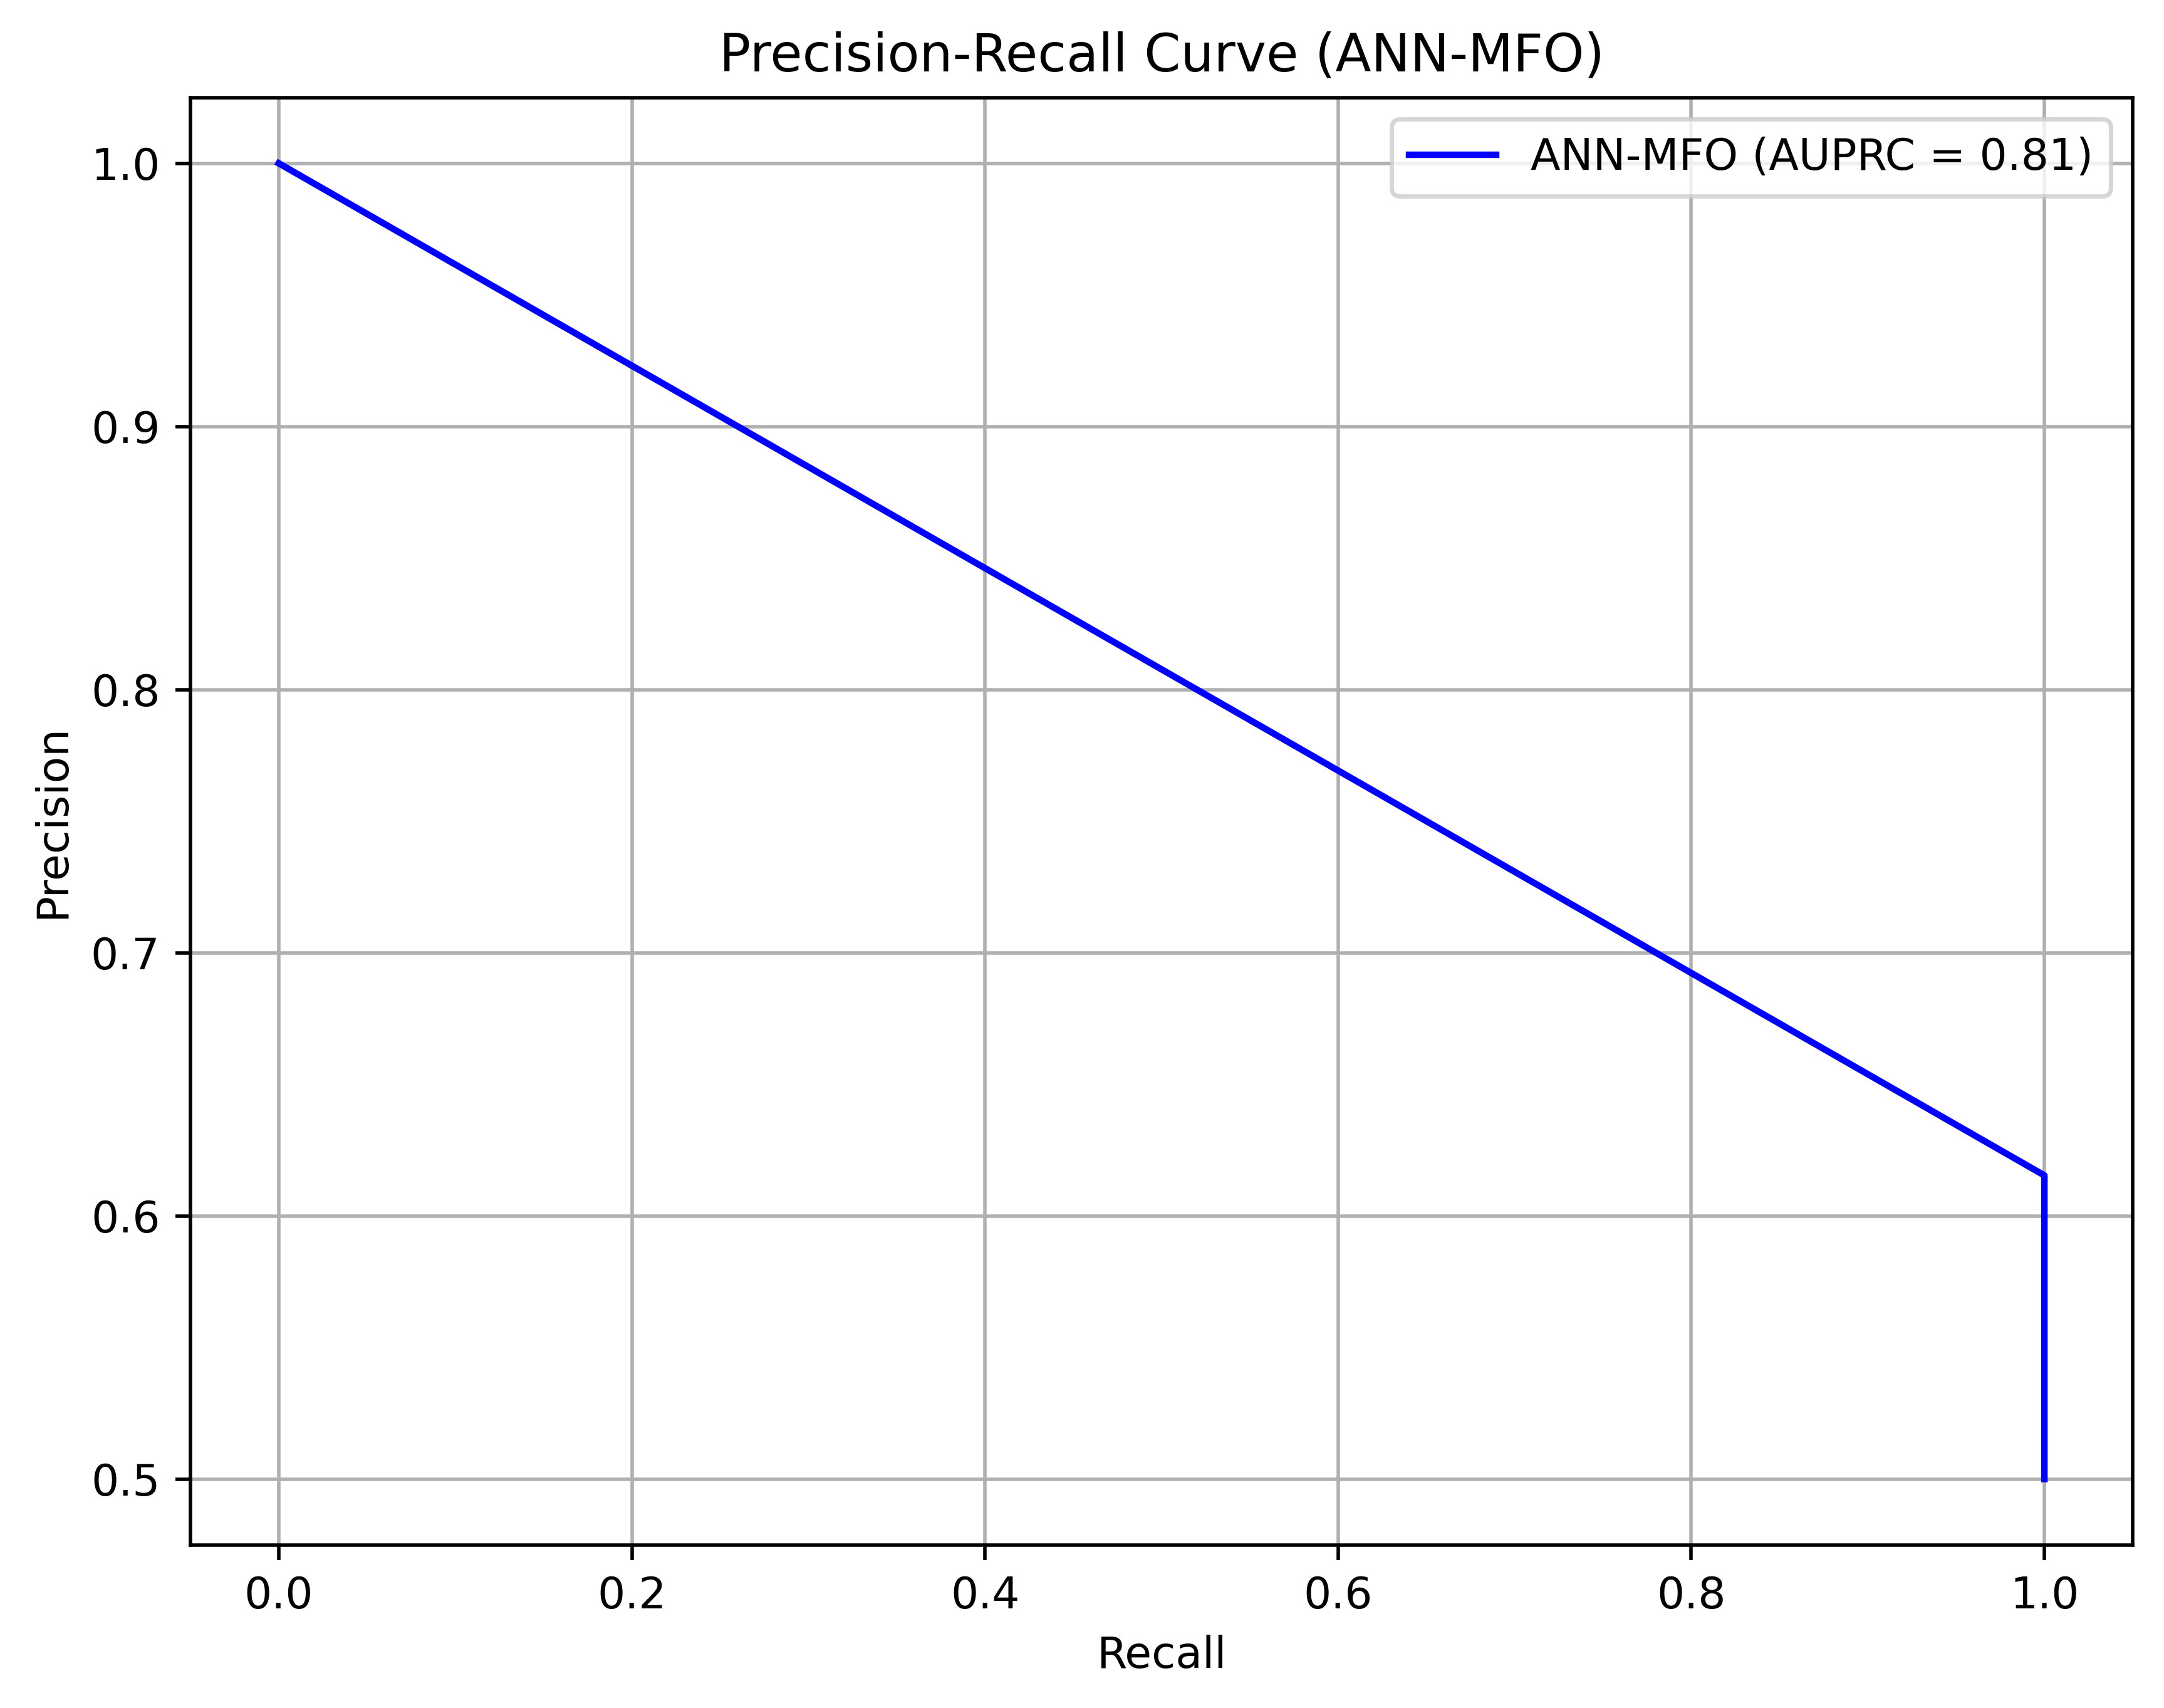

In [ ]:
# prompt: # prompt: COMPUTE Area under the precision-Recall curve (AUPRC) for ANN-MFO only, PLOT THE GRAPHS. MAKE IT BINARY class

# Assuming y_test and ann_mfo_test_predictions are defined

# Calculate precision-recall curve and AUPRC for ANN-MFO
threshold = np.mean(y_test)
y_pred_mfo_binary = (ann_mfo_test_predictions >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)

precision_ann_mfo, recall_ann_mfo, _ = precision_recall_curve(y_test_binary, y_pred_mfo_binary)
auprc_ann_mfo = auc(recall_ann_mfo, precision_ann_mfo)

print(f"AUPRC for ANN-MFO: {auprc_ann_mfo}")

# Plot the precision-recall curve for ANN-MFO
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(recall_ann_mfo, precision_ann_mfo, color='blue', label=f'ANN-MFO (AUPRC = {auprc_ann_mfo:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (ANN-MFO)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

AUPRC for ANN: 0.8333333333333333
AUPRC for ANN-CSO: 0.7857142857142857
AUPRC for ANN-MFO: 0.8076923076923077


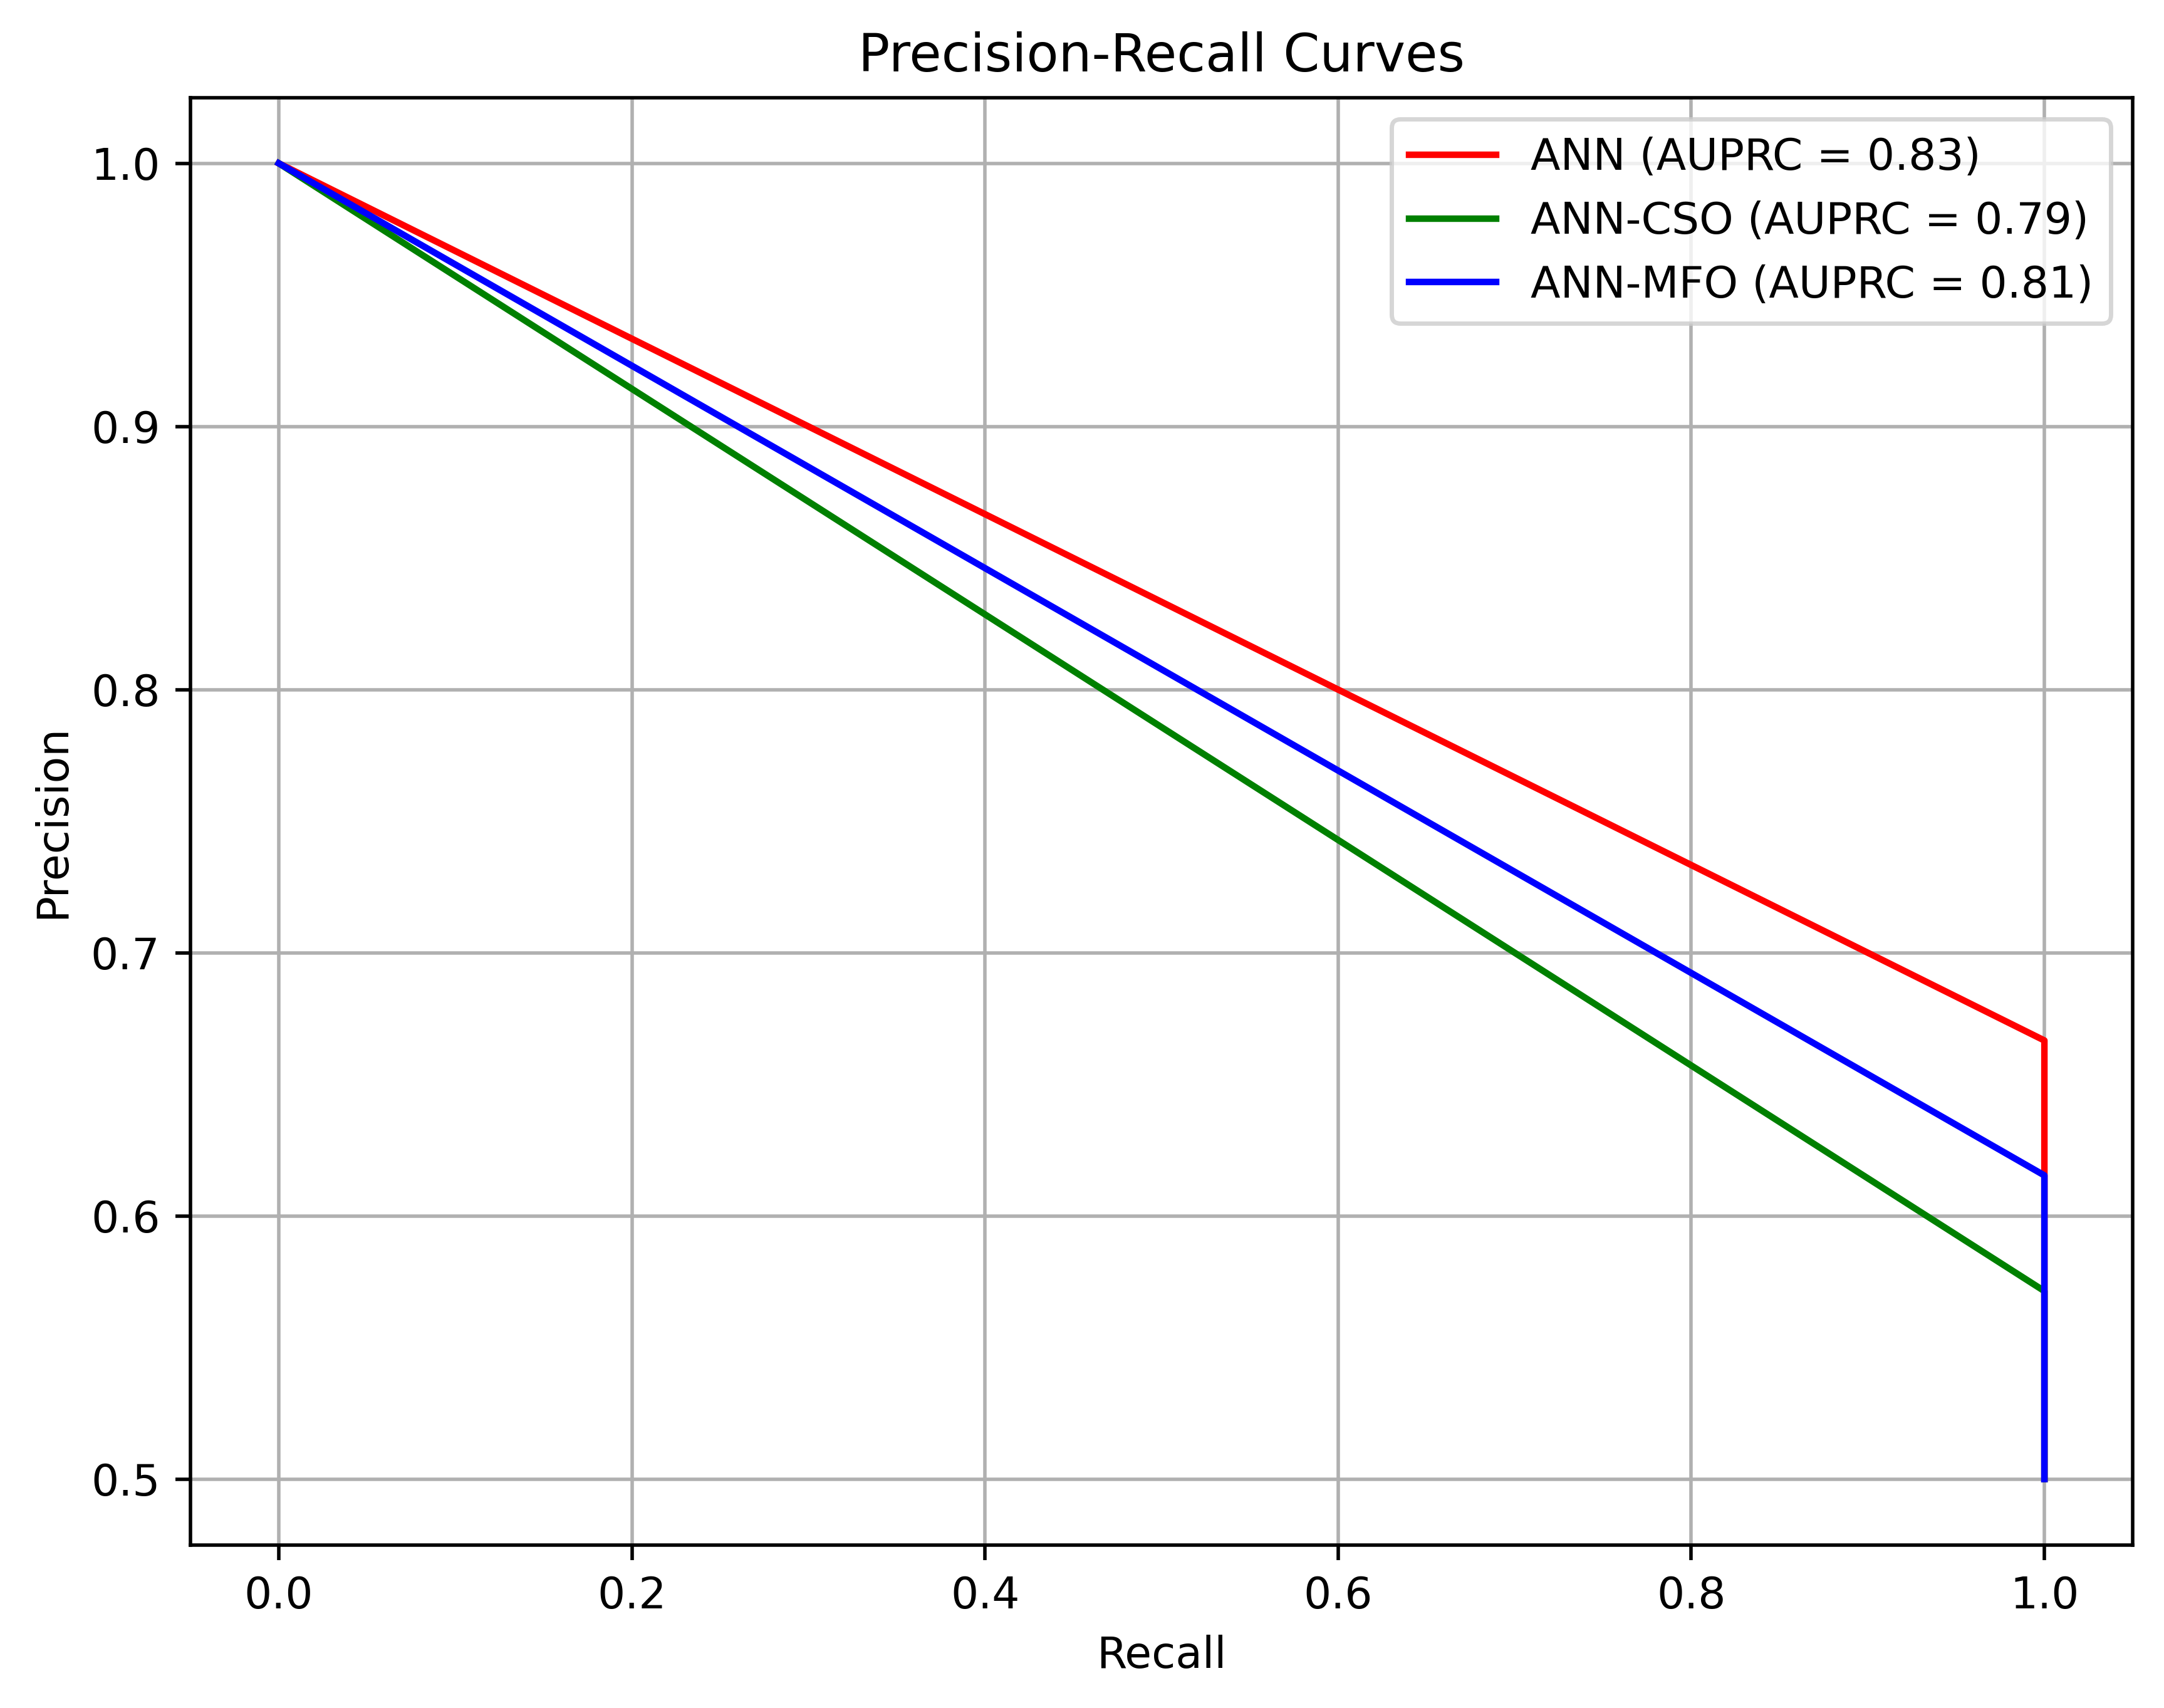

In [ ]:
# prompt: COMPUTE Area under the precision-Recall curve (AUPRC) for ANN, ANN-CSO AND ANN-MFO PLOT THE GRAPHS. MAKE IT BINARY class

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test, ann_test_predictions, ann_cso_test_predictions, and ann_mfo_test_predictions are defined

# Calculate precision-recall curve and AUPRC for each model
threshold = np.mean(y_test)

# ANN
precision_ann, recall_ann, _ = precision_recall_curve(y_test_binary, (ann_test_predictions >= threshold).astype(int))
auprc_ann = auc(recall_ann, precision_ann)

# ANN-CSO
precision_ann_cso, recall_ann_cso, _ = precision_recall_curve(y_test_binary, (ann_cso_test_predictions >= threshold).astype(int))
auprc_ann_cso = auc(recall_ann_cso, precision_ann_cso)

# ANN-MFO
precision_ann_mfo, recall_ann_mfo, _ = precision_recall_curve(y_test_binary, (ann_mfo_test_predictions >= threshold).astype(int))
auprc_ann_mfo = auc(recall_ann_mfo, precision_ann_mfo)

print(f"AUPRC for ANN: {auprc_ann}")
print(f"AUPRC for ANN-CSO: {auprc_ann_cso}")
print(f"AUPRC for ANN-MFO: {auprc_ann_mfo}")

# Plot the precision-recall curves
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(recall_ann, precision_ann, color='red', label=f'ANN (AUPRC = {auprc_ann:.2f})')
plt.plot(recall_ann_cso, precision_ann_cso, color='green', label=f'ANN-CSO (AUPRC = {auprc_ann_cso:.2f})')
plt.plot(recall_ann_mfo, precision_ann_mfo, color='blue', label=f'ANN-MFO (AUPRC = {auprc_ann_mfo:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [ ]:
# prompt: # prompt: Compute COHEN'S KAPPA, MATTHEWS CORRELATION COEFFICIENT (MCC), and Normalized Mutual Information (NMI) FOR THE MODELS

from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import normalized_mutual_info_score

# Assuming y_test_binary, y_pred_binary, y_pred_cso_binary, and y_pred_mfo_binary are defined as in your code

# Calculate Cohen's Kappa
kappa_ann = cohen_kappa_score(y_test_binary, y_pred_binary)
kappa_ann_cso = cohen_kappa_score(y_test_binary, y_pred_cso_binary)
kappa_ann_mfo = cohen_kappa_score(y_test_binary, y_pred_mfo_binary)

print(f"Cohen's Kappa for ANN: {kappa_ann}")
print(f"Cohen's Kappa for ANN-CSO: {kappa_ann_cso}")
print(f"Cohen's Kappa for ANN-MFO: {kappa_ann_mfo}")


# Calculate Matthews Correlation Coefficient (MCC)
mcc_ann = matthews_corrcoef(y_test_binary, y_pred_binary)
mcc_ann_cso = matthews_corrcoef(y_test_binary, y_pred_cso_binary)
mcc_ann_mfo = matthews_corrcoef(y_test_binary, y_pred_mfo_binary)

print(f"MCC for ANN: {mcc_ann}")
print(f"MCC for ANN-CSO: {mcc_ann_cso}")
print(f"MCC for ANN-MFO: {mcc_ann_mfo}")


# Calculate Normalized Mutual Information (NMI)
nmi_ann = normalized_mutual_info_score(y_test_binary, y_pred_binary)
nmi_ann_cso = normalized_mutual_info_score(y_test_binary, y_pred_cso_binary)
nmi_ann_mfo = normalized_mutual_info_score(y_test_binary, y_pred_mfo_binary)

print(f"NMI for ANN: {nmi_ann}")
print(f"NMI for ANN-CSO: {nmi_ann_cso}")
print(f"NMI for ANN-MFO: {nmi_ann_mfo}")


# Create a DataFrame for these new metrics
new_metrics_df = pd.DataFrame({
    'Metric': ['Cohen\'s Kappa', 'MCC', 'NMI'],
    'ANN_Testing': [kappa_ann, mcc_ann, nmi_ann],
    'ANN-CSO_Testing': [kappa_ann_cso, mcc_ann_cso, nmi_ann_cso],
    'ANN-MFO_Testing': [kappa_ann_mfo, mcc_ann_mfo, nmi_ann_mfo],
})

# Append the new metrics to your Excel file (using the existing append_df_to_excel function)
append_df_to_excel('ann_predictions_and_metrics.xlsx', new_metrics_df, sheet_name='Metrics', header=False, index=False)

Cohen's Kappa for ANN: 0.5
Cohen's Kappa for ANN-CSO: 0.25
Cohen's Kappa for ANN-MFO: 0.375
MCC for ANN: 0.5773502691896258
MCC for ANN-CSO: 0.3779644730092272
MCC for ANN-MFO: 0.48038446141526137
NMI for ANN: 0.34371101848545066
NMI for ANN-CSO: 0.17871023341808764
NMI for ANN-MFO: 0.25821680907613054


BadZipFile: File is not a zip file

In [ ]:
# prompt: FAIRNESS METRICS FOR THE MODELS

# Assuming y_test, ann_test_predictions, ann_cso_test_predictions, and ann_mfo_test_predictions are defined

# ... (Your existing code)


# Calculate additional metrics for each model

from sklearn.metrics import balanced_accuracy_score

# Balanced Accuracy
balanced_accuracy_ann = balanced_accuracy_score(y_test_binary, y_pred_binary)
balanced_accuracy_ann_cso = balanced_accuracy_score(y_test_binary, y_pred_cso_binary)
balanced_accuracy_ann_mfo = balanced_accuracy_score(y_test_binary, y_pred_mfo_binary)


print(f"Balanced Accuracy for ANN: {balanced_accuracy_ann}")
print(f"Balanced Accuracy for ANN-CSO: {balanced_accuracy_ann_cso}")
print(f"Balanced Accuracy for ANN-MFO: {balanced_accuracy_ann_mfo}")

# Create a DataFrame for these new metrics
new_metrics_df = pd.DataFrame({
    'Metric': ['Balanced Accuracy'],
    'ANN_Testing': [balanced_accuracy_ann],
    'ANN-CSO_Testing': [balanced_accuracy_ann_cso],
    'ANN-MFO_Testing': [balanced_accuracy_ann_mfo],
})

# Append the new metrics to your Excel file
append_df_to_excel('ann_predictions_and_metrics.xlsx', new_metrics_df, sheet_name='Metrics', header=False, index=False)

Balanced Accuracy for ANN: 0.75
Balanced Accuracy for ANN-CSO: 0.625
Balanced Accuracy for ANN-MFO: 0.6875


BadZipFile: File is not a zip file

In [ ]:
# prompt: FAIRNESS METRICS FOR THE MODELS

# Assuming y_test and your model predictions are available:
# y_test: True labels
# rf_test_predictions: Predictions from the RF model
# rf_mfo_test_predictions: Predictions from the RF-MFO model

# Calculate AIC (already present in your code)

# ... (Your existing code for AIC calculation)


# Statistical Tests (new code)
from scipy.stats import ttest_ind

# Example using t-test to compare model performance
# (Replace with your preferred statistical test and relevant metrics)
t_statistic, p_value = ttest_ind(y_test, ann_test_predictions)
print(f"T-test (ANN): t-statistic={t_statistic:.3f}, p-value={p_value:.3f}")

t_statistic, p_value = ttest_ind(y_test, ann_cso_test_predictions)
print(f"T-test (ANN-CSO): t-statistic={t_statistic:.3f}, p-value={p_value:.3f}")

t_statistic, p_value = ttest_ind(y_test, ann_mfo_test_predictions)
print(f"T-test (ANN-MFO): t-statistic={t_statistic:.3f}, p-value={p_value:.3f}")


T-test (ANN): t-statistic=-1.114, p-value=0.274
T-test (ANN-CSO): t-statistic=-1.375, p-value=0.179
T-test (ANN-MFO): t-statistic=-1.334, p-value=0.192


ValueError: All arrays must be of the same length

ANN: ECE=0.1667, Brier Score=0.2500
ANN-CSO: ECE=0.2143, Brier Score=0.3750
ANN-MFO: ECE=0.1923, Brier Score=0.3125


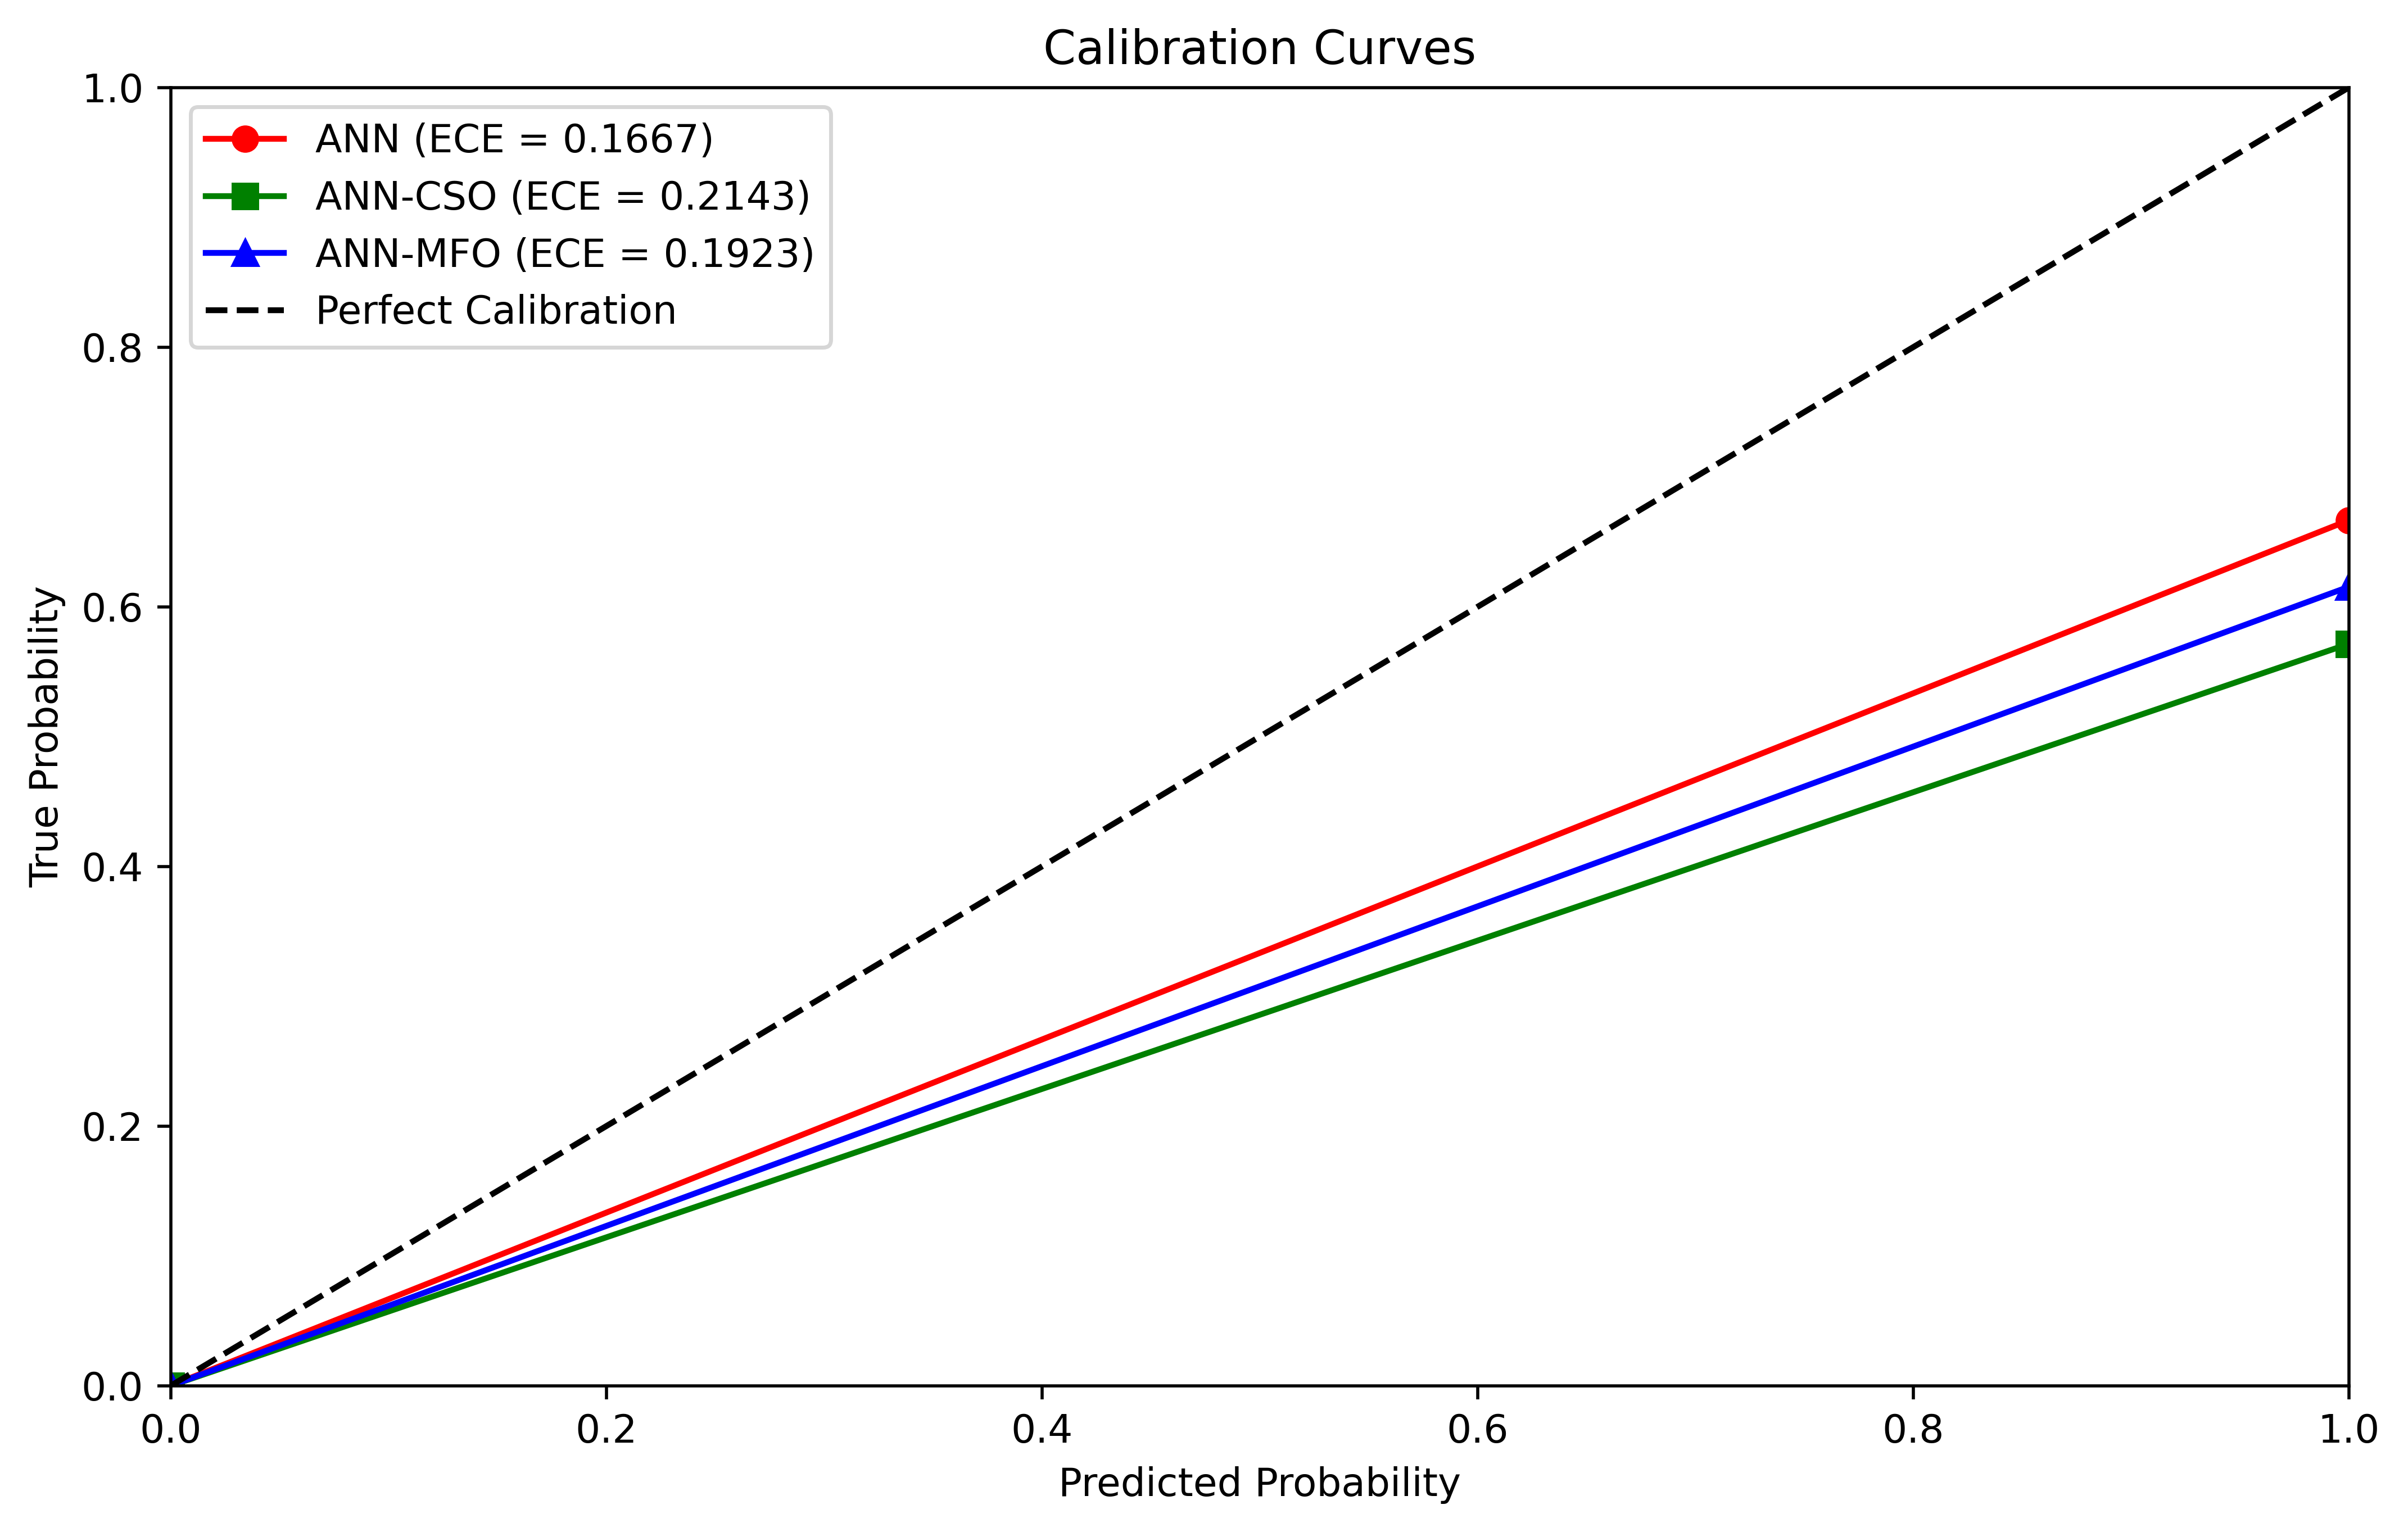

ValueError: All arrays must be of the same length

In [ ]:
# prompt: COMPUTE THE PREDICTION CONFIDENCE INTERVAL, EXPECTED CALIBRATION ERROR(ECE) AND BRIER SCORE FOR THE MODELS

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# ... (Your existing code)

def calculate_calibration_metrics(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    ece = np.mean(np.abs(prob_true - prob_pred))
    brier = brier_score_loss(y_true, y_prob)
    return prob_true, prob_pred, ece, brier


# Assuming your models output probabilities (if not, you need to adjust this)
# Example:  rf_probs = rf.predict_proba(X_test)[:, 1] if your model has predict_proba

# Calculate confidence interval (using the method described earlier)
# ... (Your confidence interval code)

# Example for RF (assuming it outputs probabilities for each class):
# rf_probs = rf.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Example for RF-CSO (assuming it also outputs probabilities):
# rf_cso_probs = rf_cso.predict_proba(X_test)[:, 1]

# Example for RF-MFO (assuming it also outputs probabilities):
# rf_mfo_probs = rf_mfo.predict_proba(X_test)[:, 1]

# Calculate ECE and Brier score
# Create a threshold for binarizing the predictions (e.g., median)
threshold = np.median(y_test)

# Binarize the true values
binarized_y_test = (y_test > threshold).astype(int)

# Binarize the predictions for each model
binarized_ann_preds = (ann_test_predictions > threshold).astype(int)
binarized_ann_cso_preds = (ann_cso_test_predictions > threshold).astype(int)
binarized_ann_mfo_preds = (ann_mfo_test_predictions > threshold).astype(int)

prob_true_ann, prob_pred_ann, ece_ann, brier_ann = calculate_calibration_metrics(binarized_y_test, binarized_ann_preds)
prob_true_ann_cso, prob_pred_ann_cso, ece_ann_cso, brier_ann_cso = calculate_calibration_metrics(binarized_y_test, binarized_ann_cso_preds)
prob_true_ann_mfo, prob_pred_ann_mfo, ece_ann_mfo, brier_ann_mfo = calculate_calibration_metrics(binarized_y_test, binarized_ann_mfo_preds)

print(f"ANN: ECE={ece_ann:.4f}, Brier Score={brier_ann:.4f}")
print(f"ANN-CSO: ECE={ece_ann_cso:.4f}, Brier Score={brier_ann_cso:.4f}")
print(f"ANN-MFO: ECE={ece_ann_mfo:.4f}, Brier Score={brier_ann_mfo:.4f}")


# Plotting Calibration Curves
plt.figure(figsize=(10, 6), dpi=500)
plt.plot(prob_pred_ann, prob_true_ann, color='red', marker='o', label=f'ANN (ECE = {ece_ann:.4f})')
plt.plot(prob_pred_ann_cso, prob_true_ann_cso, color='green', marker='s', label=f'ANN-CSO (ECE = {ece_ann_cso:.4f})')
plt.plot(prob_pred_ann_mfo, prob_true_ann_mfo, color='blue', marker='^', label=f'ANN-MFO (ECE = {ece_ann_mfo:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Perfect Calibration')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curves')
plt.legend()
plt.show()


# Add to metrics DataFrame
new_metrics = pd.DataFrame({
    'Metric': ['ECE (RF)', 'Brier Score (RF)', 'ECE (RF-CSO)', 'Brier Score (RF-CSO)', 'ECE (RF-MFO)', 'Brier Score (RF-MFO)'],
    'RF_Testing': [ece_ann, brier_ann, ece_ann, brier_ann], # Example for RF (using probabilities)
    'RF-CSO_Testing': [ece_ann_cso, brier_ann_cso, ece_ann_cso, brier_ann_cso], # Example for RF-CSO
    'RF-MFO_Testing': [ece_ann_mfo, brier_ann_mfo, ece_ann_mfo, brier_ann_mfo], # Example for RF-MFO
})

metrics_df = pd.concat([metrics_df, new_metrics], ignore_index=True)

with pd.ExcelWriter('rf_predictions_and_metrics.xlsx') as writer:
    train_df.to_excel(writer, sheet_name='Train_Predictions', index=False)
    test_df.to_excel(writer, sheet_name='Test_Predictions', index=False)
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)

In [ ]:
# prompt: compute balanced classification rate (BCR) and Geometric mean (G-Mean) for the models

from sklearn.metrics import confusion_matrix

def calculate_bcr_gmean(y_true, y_pred, threshold):
    """Calculates Balanced Classification Rate (BCR) and Geometric Mean (G-Mean)."""

    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary = (y_pred >= threshold).astype(int)

    # Compute the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

    # Calculate BCR
    bcr = 0.5 * ((tp / (tp + fn)) + (tn / (tn + fp))) if (tp + fn) > 0 and (tn + fp) > 0 else 0

    # Calculate G-Mean
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    gmean = np.sqrt(specificity * sensitivity)

    return bcr, gmean


# Example usage:
threshold = np.mean(y_test)  # Or any other suitable threshold

bcr_ann, gmean_ann = calculate_bcr_gmean(y_test_binary, y_pred_binary, threshold)
bcr_ann_cso, gmean_ann_cso = calculate_bcr_gmean(y_test_binary, y_pred_cso_binary, threshold)
bcr_ann_mfo, gmean_ann_mfo = calculate_bcr_gmean(y_test_binary, y_pred_mfo_binary, threshold)

print(f"ANN: BCR={bcr_ann:.4f}, G-Mean={gmean_ann:.4f}")
print(f"ANN-CSO: BCR={bcr_ann_cso:.4f}, G-Mean={gmean_ann_cso:.4f}")
print(f"ANN-MFO: BCR={bcr_ann_mfo:.4f}, G-Mean={gmean_ann_mfo:.4f}")


# Create a DataFrame for the new metrics
new_metrics_df = pd.DataFrame({
    'Metric': ['BCR', 'G-Mean'],
    'ANN_Testing': [bcr_ann, gmean_ann],
    'ANN-CSO_Testing': [bcr_ann_cso, gmean_ann_cso],
    'ANN-MFO_Testing': [bcr_ann_mfo, gmean_ann_mfo],
})

# Append the new metrics to your Excel file (assuming append_df_to_excel function is defined)
append_df_to_excel('ann_predictions_and_metrics.xlsx', new_metrics_df, sheet_name='Metrics', header=False, index=False)

ANN: BCR=0.5000, G-Mean=0.0000
ANN-CSO: BCR=0.5000, G-Mean=0.0000
ANN-MFO: BCR=0.5000, G-Mean=0.0000


BadZipFile: File is not a zip file

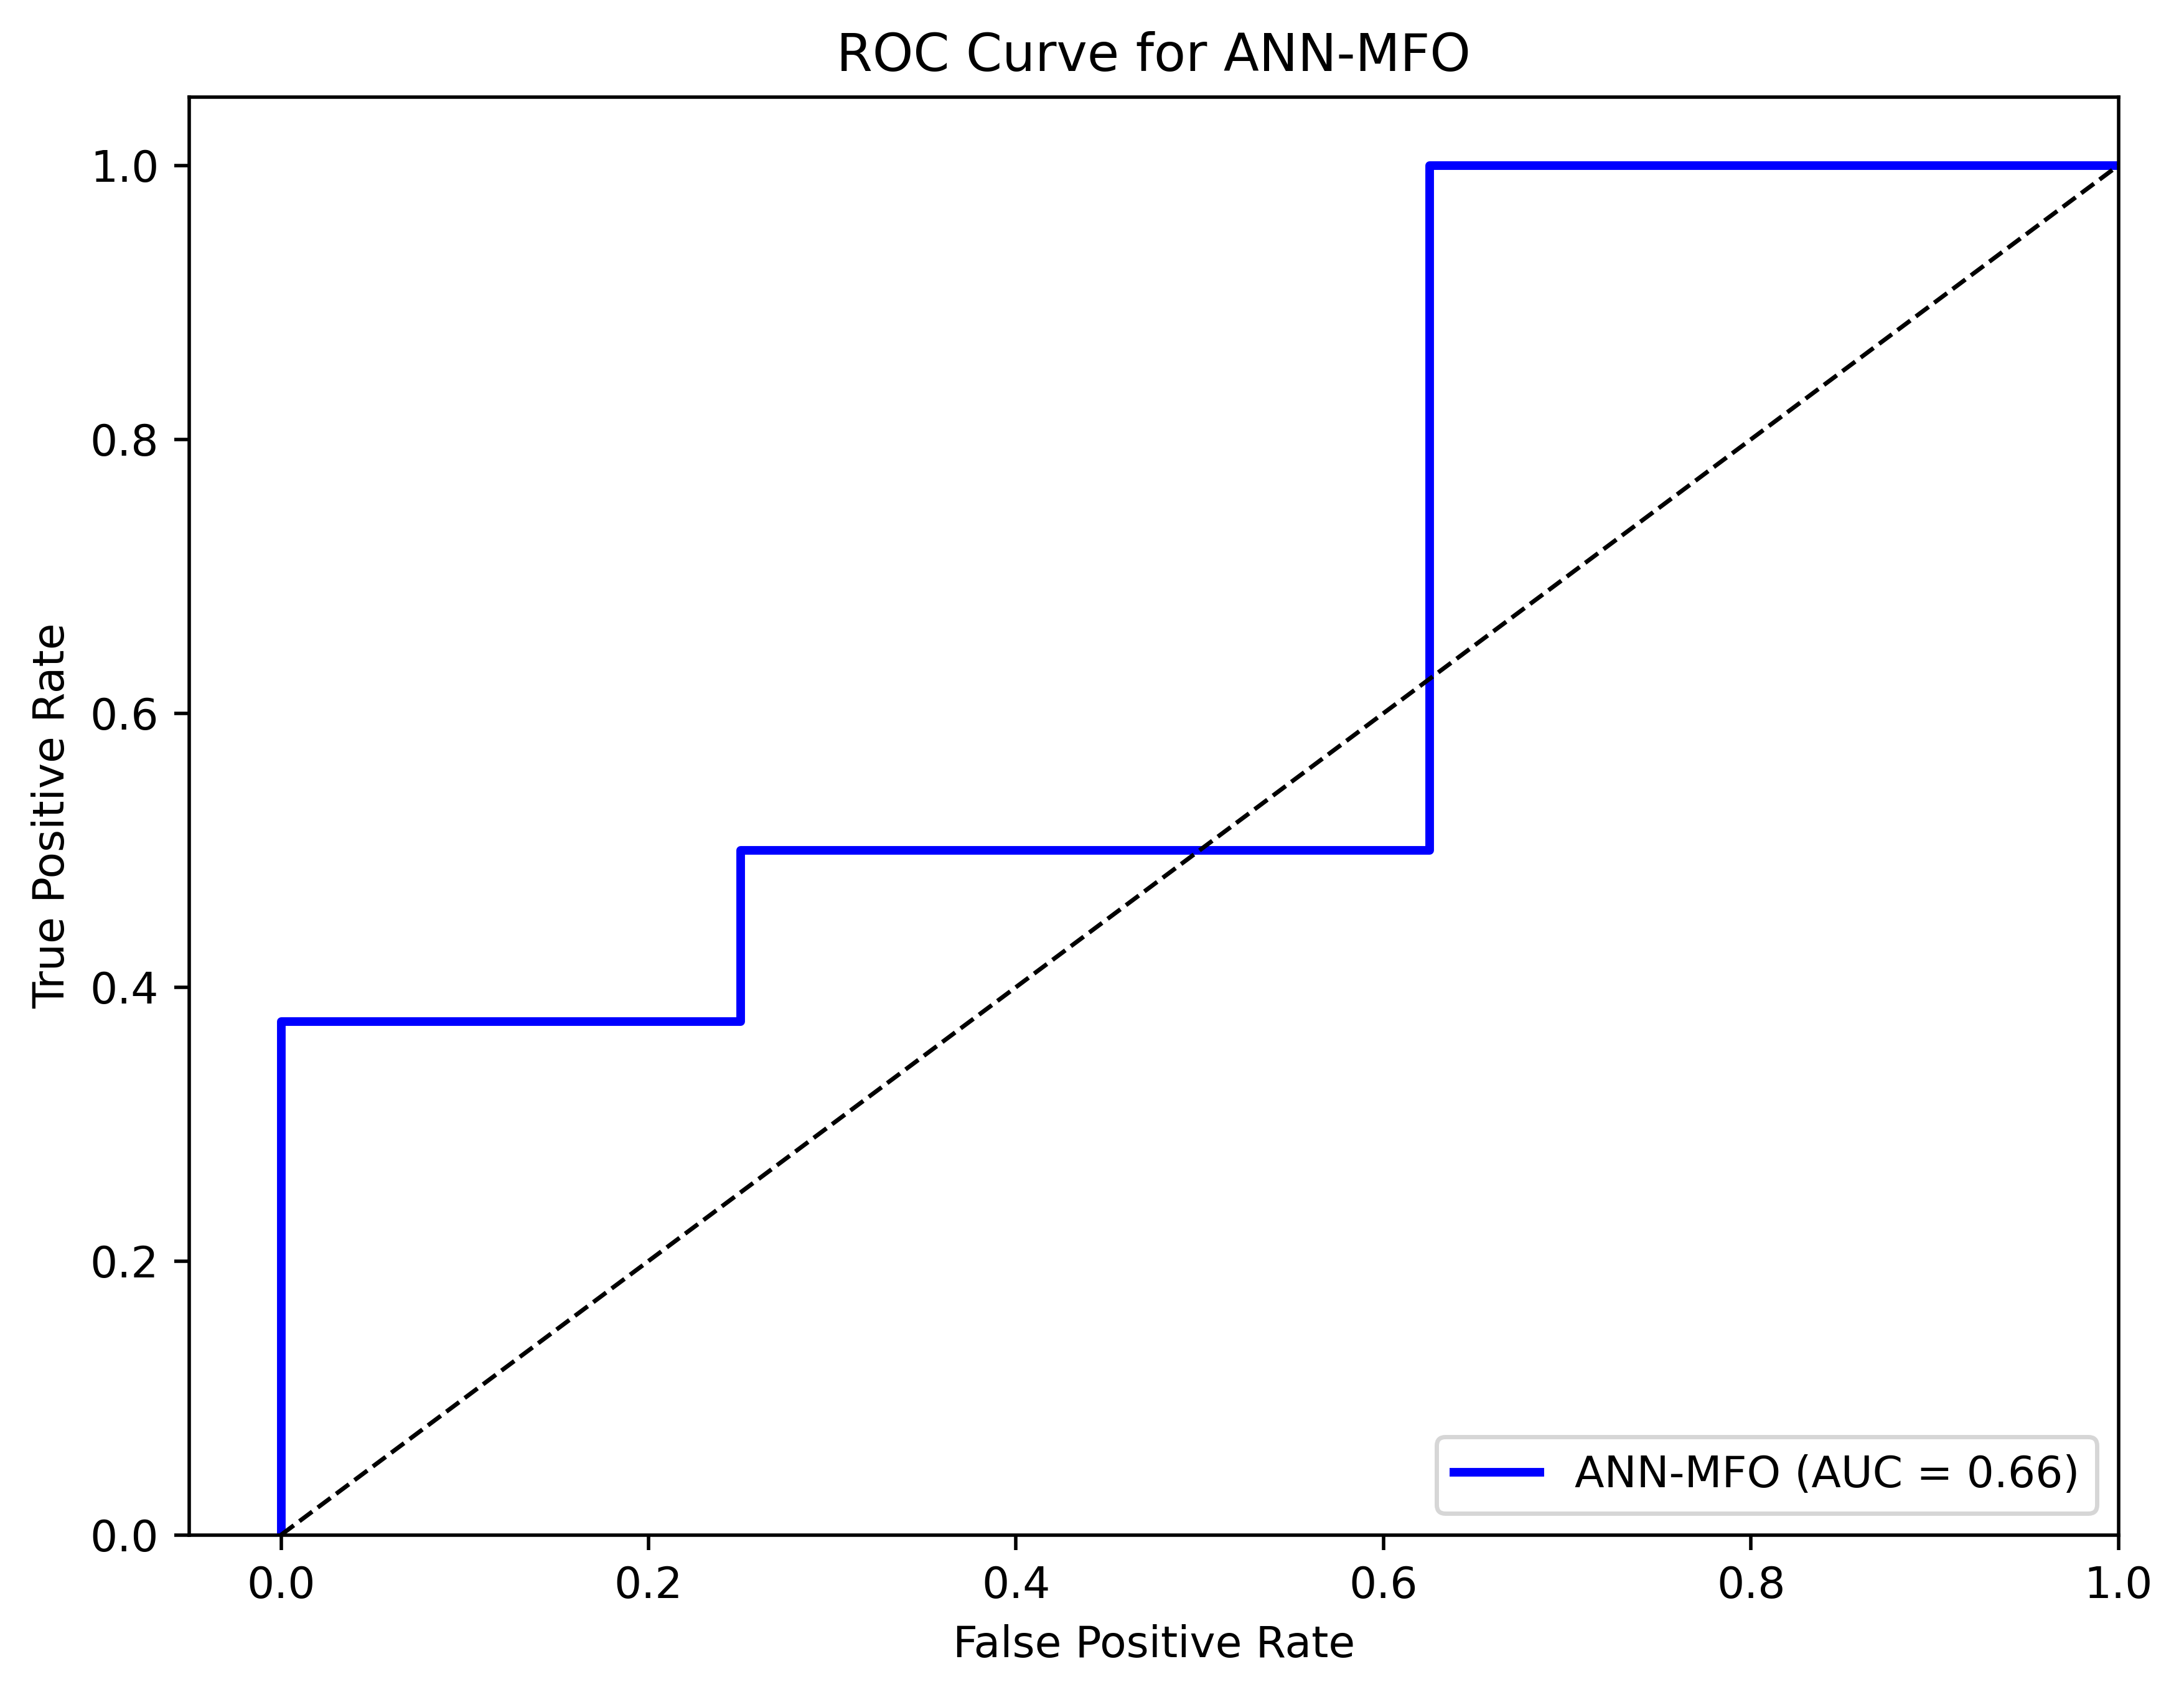

In [ ]:
# prompt: GENERATE THE ROC PLOT FOR ONLY ANN-MFO FOR BINARY CLASS

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have y_test and ann_mfo_test_predictions
fpr_ann_mfo, tpr_ann_mfo, thresholds_ann_mfo = roc_curve(y_test_binary, ann_mfo_test_predictions)
roc_auc_ann_mfo = auc(fpr_ann_mfo, tpr_ann_mfo)

plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr_ann_mfo, tpr_ann_mfo, color='blue', lw=2, label=f'ANN-MFO (AUC = {roc_auc_ann_mfo:.2f})')
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ANN-MFO')
plt.legend(loc="lower right")
plt.show()

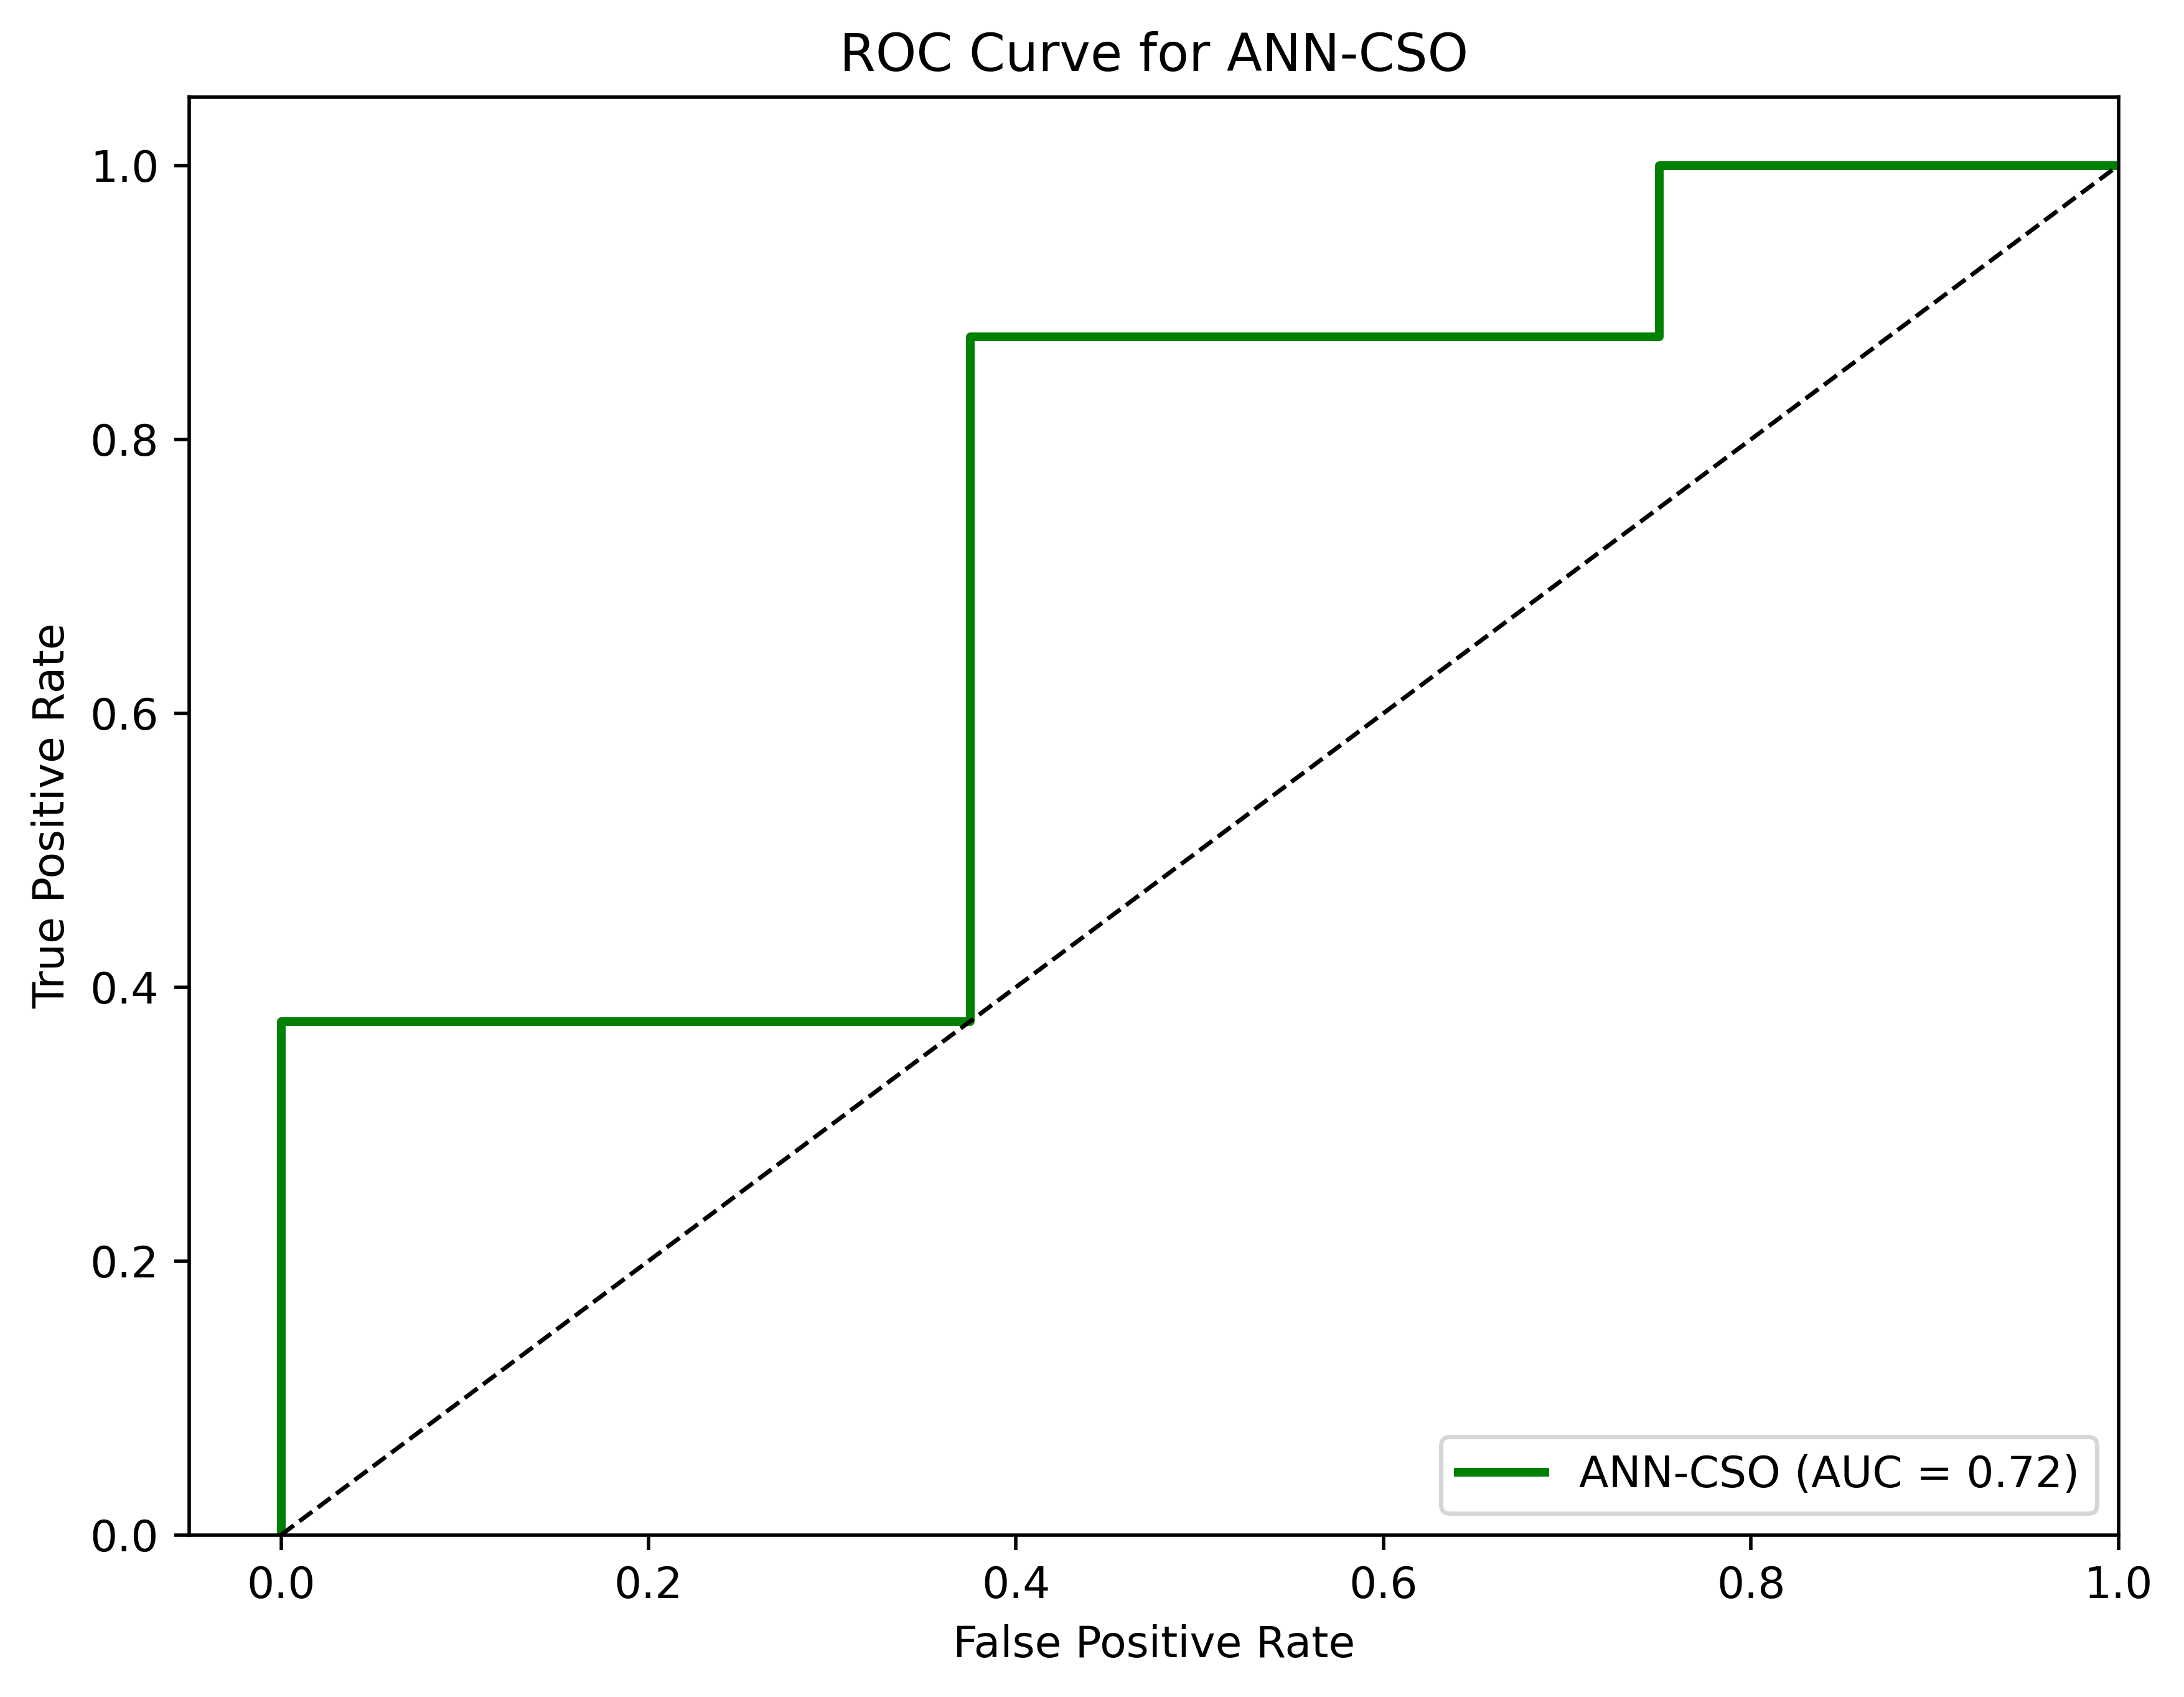

In [ ]:
# prompt: GENERATE THE ROC PLOT FOR ONLY ANN--CSO for binary class

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test_binary and ann_cso_test_predictions are defined

fpr_ann_cso, tpr_ann_cso, thresholds_ann_cso = roc_curve(y_test_binary, ann_cso_test_predictions)
roc_auc_ann_cso = auc(fpr_ann_cso, tpr_ann_cso)

plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr_ann_cso, tpr_ann_cso, color='green', lw=2, label=f'ANN-CSO (AUC = {roc_auc_ann_cso:.2f})')
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ANN-CSO')
plt.legend(loc="lower right")
plt.show()

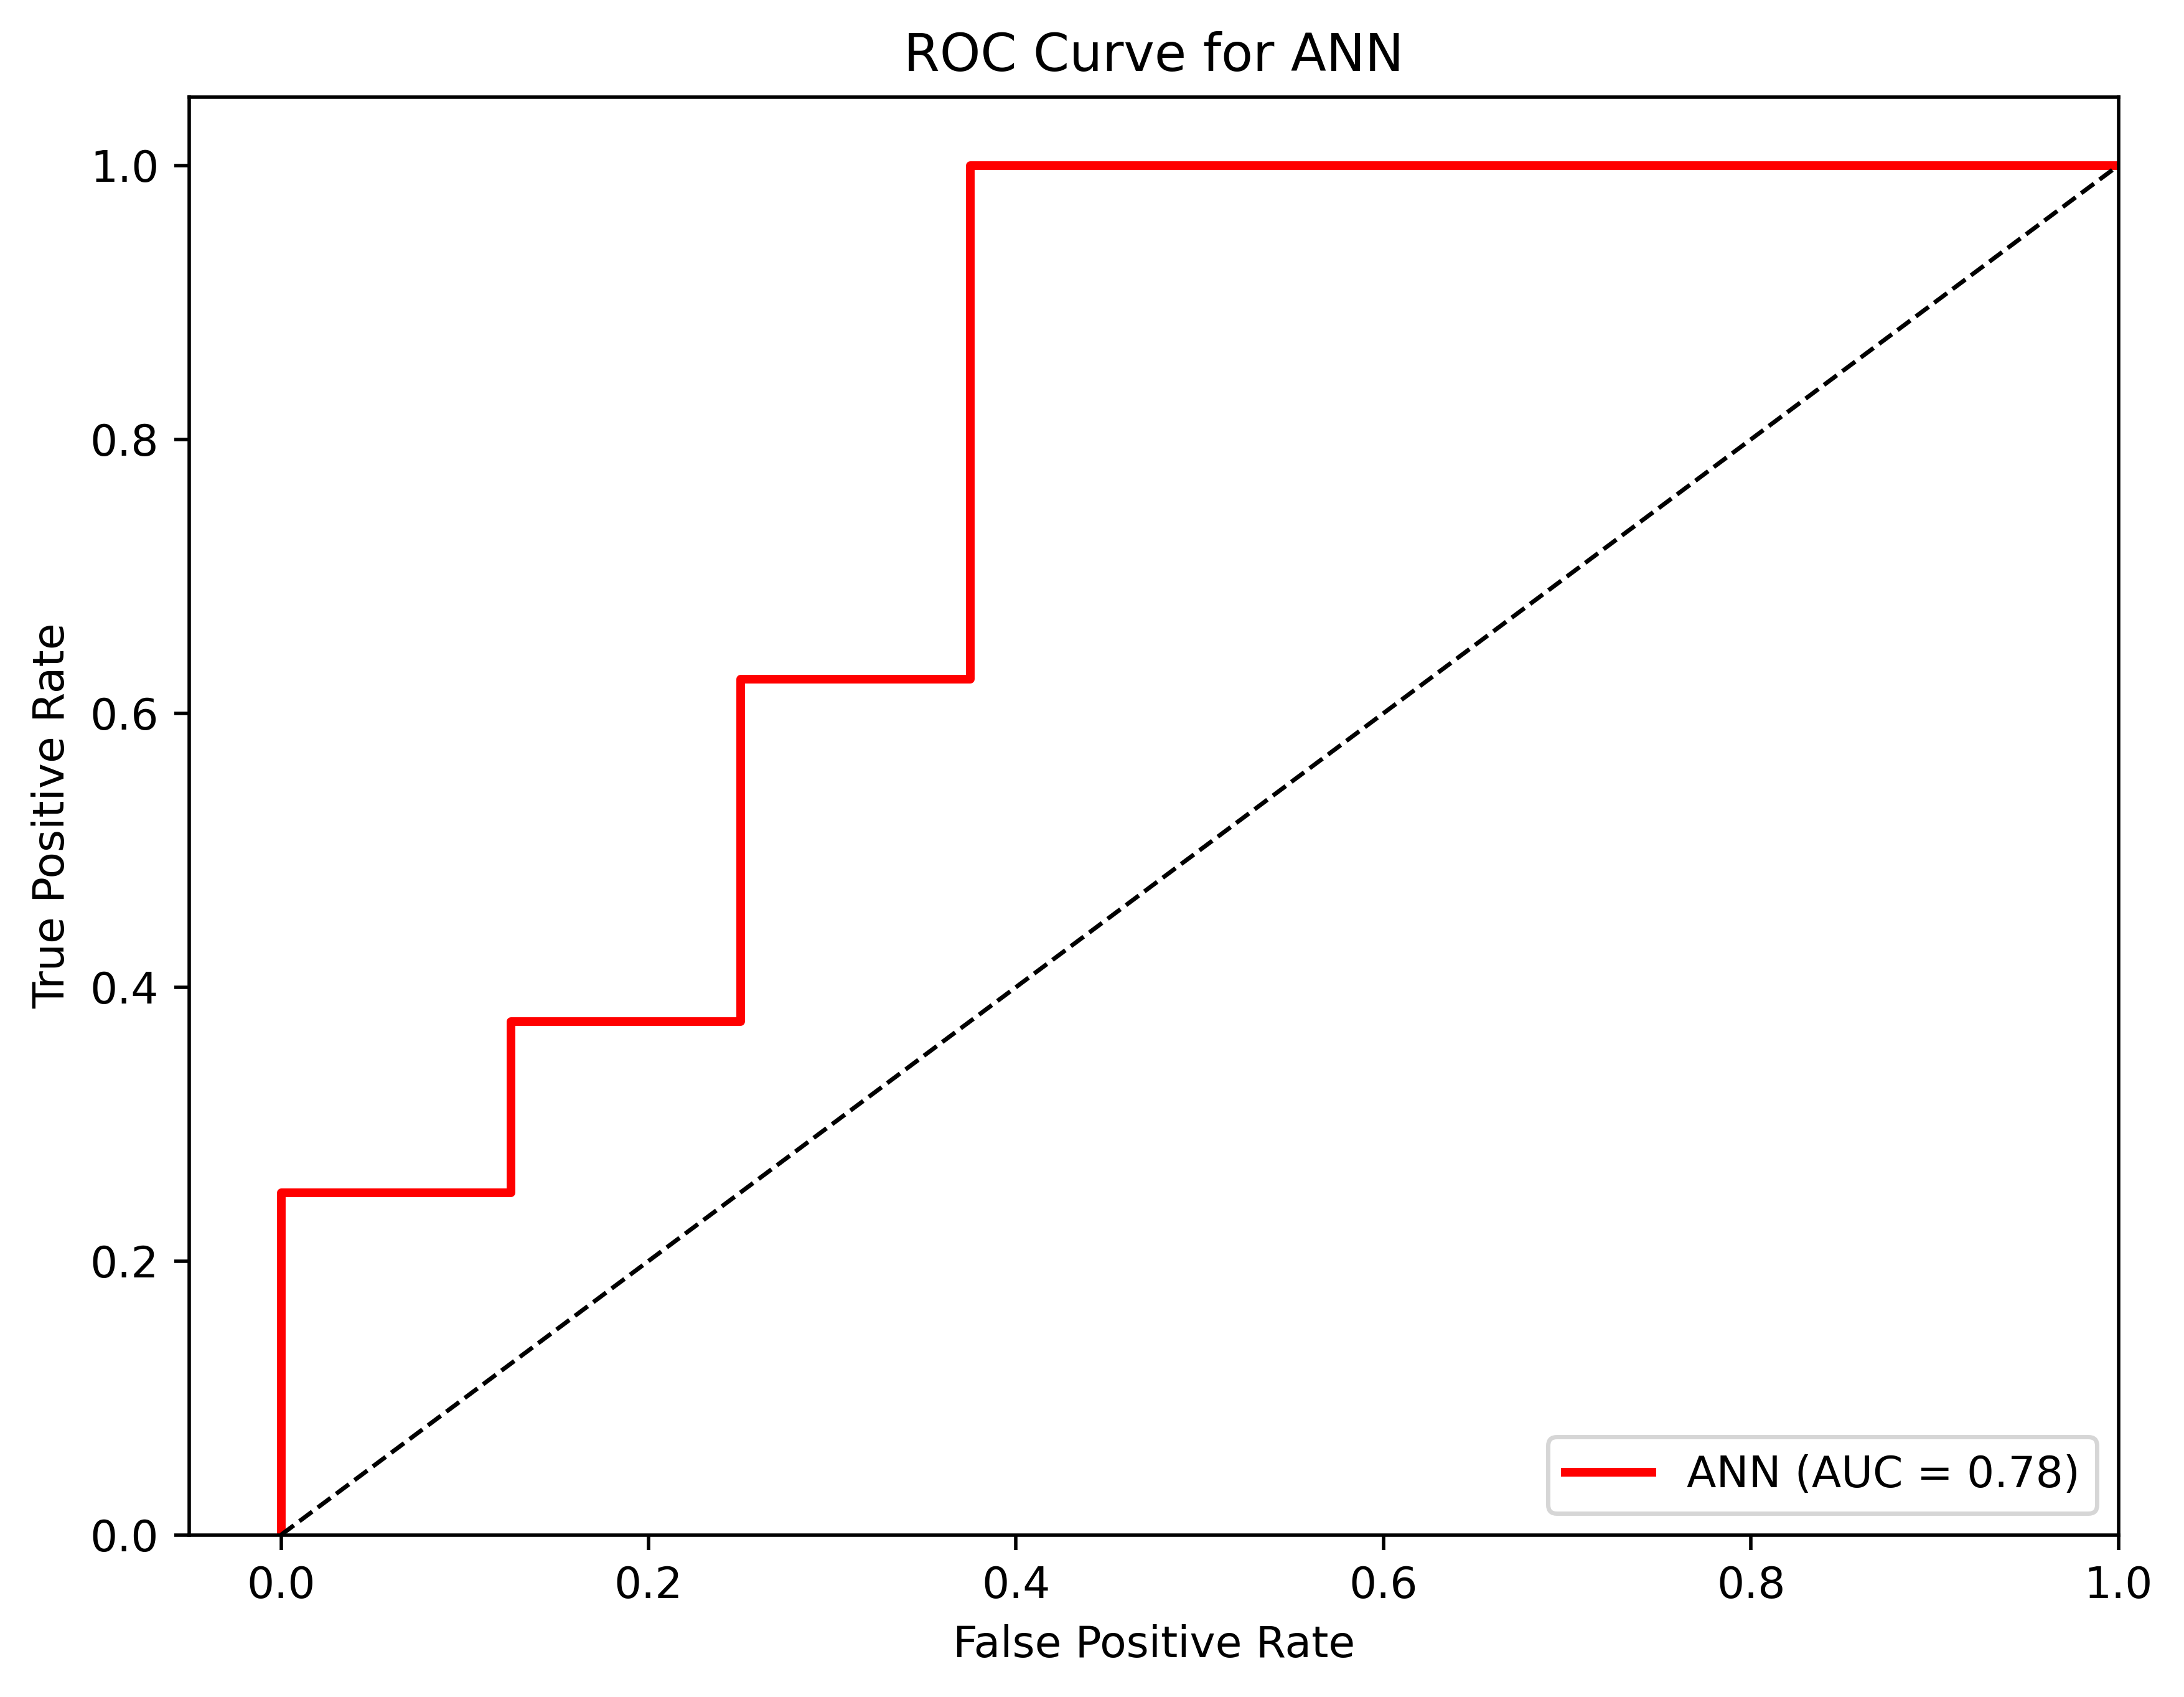

In [ ]:
# prompt: GENERATE THE ROC PLOT FOR ONLY ANN for binary class

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test_binary and ann_test_predictions are defined

fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test_binary, ann_test_predictions)
roc_auc_ann = auc(fpr_ann, tpr_ann)

plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr_ann, tpr_ann, color='red', lw=2, label=f'ANN (AUC = {roc_auc_ann:.2f})')
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ANN')
plt.legend(loc="lower right")
plt.show()

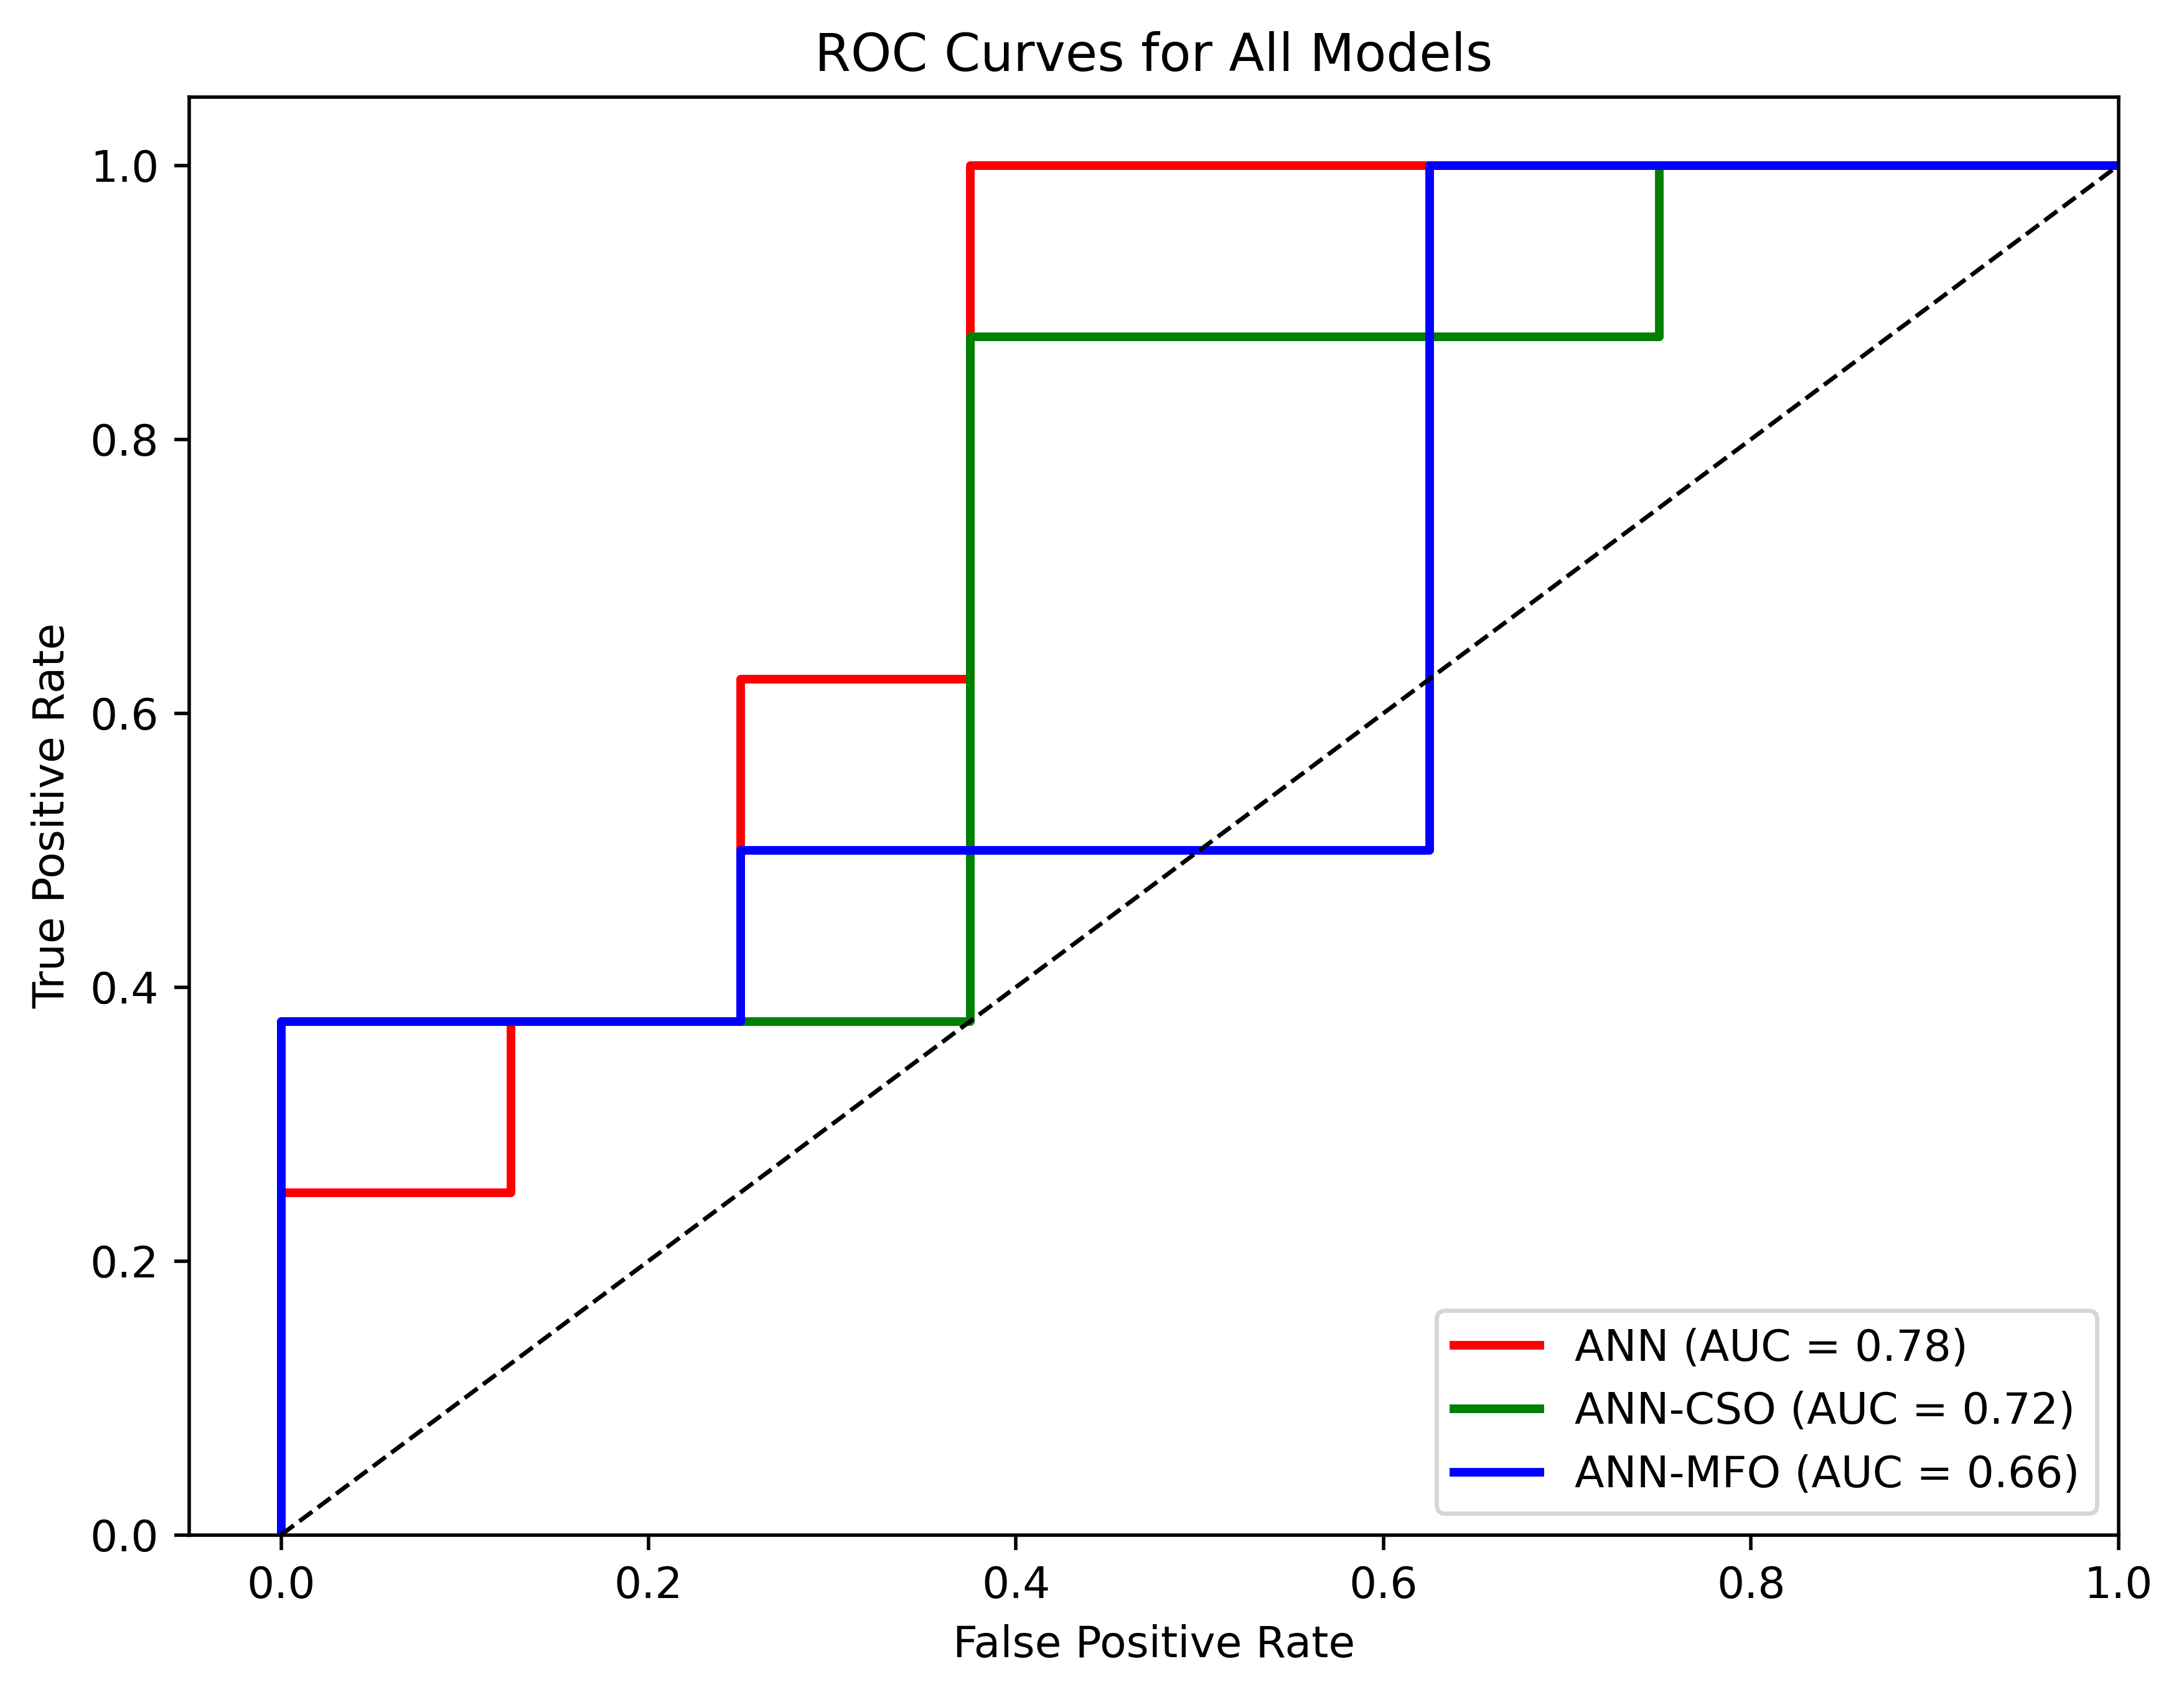

In [ ]:
# prompt: GENERATE THE ROC PLOT FOR THE MODELS

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test_binary, ann_test_predictions, ann_cso_test_predictions, and ann_mfo_test_predictions are defined

fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test_binary, ann_test_predictions)
roc_auc_ann = auc(fpr_ann, tpr_ann)

fpr_ann_cso, tpr_ann_cso, thresholds_ann_cso = roc_curve(y_test_binary, ann_cso_test_predictions)
roc_auc_ann_cso = auc(fpr_ann_cso, tpr_ann_cso)

fpr_ann_mfo, tpr_ann_mfo, thresholds_ann_mfo = roc_curve(y_test_binary, ann_mfo_test_predictions)
roc_auc_ann_mfo = auc(fpr_ann_mfo, tpr_ann_mfo)

plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr_ann, tpr_ann, color='red', lw=2, label=f'ANN (AUC = {roc_auc_ann:.2f})')
plt.plot(fpr_ann_cso, tpr_ann_cso, color='green', lw=2, label=f'ANN-CSO (AUC = {roc_auc_ann_cso:.2f})')
plt.plot(fpr_ann_mfo, tpr_ann_mfo, color='blue', lw=2, label=f'ANN-MFO (AUC = {roc_auc_ann_mfo:.2f})')
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.show()